# 🧠 Contexto do Negócio

O **CFO** solicitou aos **Gerentes de Loja** uma **previsão diária de vendas para as próximas 6 semanas**.
Após a reunião, cada gerente pediu sua previsão específica por loja, para apoiar metas, compras e escalas.

# 🎯 Objetivo

Prever **vendas diárias por loja** (granularidade loja × dia) para as **próximas 6 semanas**, entregando uma saída que possa ser consumida por API e por um BOT (Telegram).

# 👥 Stakeholders

- **Solicitante (dono do problema)**: CFO

- **Usuários**: Gerentes de Loja, Operações, Comercial

- **Equipe executora**: Dados/DS + Engenharia/Infra

# 📦 Entregáveis

- Tabela/arquivo com previsões: store_id, date, yhat, yhat_lower, yhat_upper

- Endpoint de API (FastAPI) e integração com BOT no Telegram

- Notebook com EDA, modelagem e validação

- Documentação de uso e limitações

# 📏 Métricas de Sucesso

- **MAPE** e/ou **sMAPE** por loja ≤ alvo definido (ex.: **MAPE** ≤ **12%**)

- Cobertura completa de **6 semanas (42 dias)** para todas as lojas ativas

- **SLA** de resposta do endpoint (ex.: ≤ 500 ms por loja consultada em cache)

# 📚 Dados (alto nível)

- **Store metadata**: tipo da loja, competição, promoções

- **Calendário**: feriados estaduais/locais, férias escolares

- **Histórico de vendas**: série diária por loja

- **Sinais de promoção**: Promo, Promo2, janelas de campanha

# 🔬 Assunções e Restrições

- Lojas fechadas têm vendas **0** nos dias fechados

- Mudanças estruturais (ex.: reformas) podem afetar a acurácia local

- Períodos com dados ausentes serão tratados com regras de imputação conservadoras

- Previsão **não** considera rupturas de estoque não registradas

# 🗺️ Tópicos para entender o problema

1. **Motivação (Contexto)**: prever demanda para planejar equipe, compras e metas.

2. **Causa raiz (Por quê?)**: decisões diárias sem previsões consistentes geram custo e perda de venda.

3. **Dono do problema (Quem?)**: CFO (solicitante) e Gerentes (usuários principais).

4. **Formato da solução (Como?)**: previsões **loja × dia × 6 semanas**, via **API** e **BOT**, com faixas de incerteza.

# 🔁 Processo CRISP-DM (adaptado a Data Science)

## CRISP-DM = Cross-Industry Standard Process for Data Mining (ciclo iterativo)

1. **Entendimento do Negócio** → 
2. **Entendimento dos Dados** → 
3. **Preparação dos Dados** → 
4. **Modelagem** → 
5. **Avaliação** → 
6. **Implantação** → retorna ao passo 1 quando necessário.

# Ciclo de entrega

- **Versão 1 End-to-End** rápida para validar valor com usuários

- **Aprendizados** alimentam novas iterações

- **Riscos/limitações** registrados na doc para decisões de negócio

# 🧭 Roteiro deste notebook

1. **Contexto & Objetivo** (esta seção)

2. **Dados & Dicionário** (campos e fontes)

3. **EDA rápida** (sazonalidade, tendências, outliers)

4. **Preparação** (limpeza, encoding, calendários, feriados)

5. **Modelagem** (baseline → modelos candidatos → seleção)

6. **Validação** (backtesting por loja, métricas)

7. **Geração das previsões 6 semanas** (com intervalos)

8. **Formato de saída & amostras**

9. **Próximos passos & riscos**


# 0.0 Imports essenciais (adicione sob demanda nas seções específicas)

In [104]:
from __future__ import annotations

import os
import math
import json
import random
import warnings
from pathlib import Path
from typing import Callable, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inflection  # para renomear colunas em snake_case
import xgboost as xgb

# modelagem leve de início; importe libs pesadas (xgboost, boruta, gridsearch) na hora de usar
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## 0.1 Config & Paths (reprodutibilidade + portabilidade)

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Display & warnings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)
warnings.simplefilter("once", category=UserWarning)

# Project root = diretório do notebook (fallback) ou variável de ambiente
PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", Path.cwd())).resolve()

# Estrutura de pastas padrão para repositório
DATA_DIR   = PROJECT_ROOT / "data"
RAW_DIR    = DATA_DIR / "raw"
MODELS_DIR = PROJECT_ROOT / "models"
ARTIF_DIR  = PROJECT_ROOT / "artifacts"

for p in [RAW_DIR, MODELS_DIR, ARTIF_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Caminhos de entrada (ajuste se necessário, mas mantenha relativos)
TRAIN_PATH = os.getenv("ROSSMANN_TRAIN", str(RAW_DIR / "train.csv"))
STORE_PATH = os.getenv("ROSSMANN_STORE", str(RAW_DIR / "store.csv"))

## 0.2 Helpers (métricas & utilitários)

In [102]:
def cramers_v(x: pd.Series, y: pd.Series) -> float:
    """
    Cramér's V com correção de bias de Bergsma (2013).
    Retorna NaN se alguma tabela estiver vazia.
    """
    cm = pd.crosstab(x, y).values
    if cm.size == 0:
        return np.nan

    n = cm.sum()
    r, k = cm.shape

    # qui-quadrado sem correção de Yates
    from scipy.stats import chi2_contingency
    chi2 = chi2_contingency(cm, correction=False)[0]

    if n <= 1:
        return 0.0

    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    denom = min(kcorr - 1, rcorr - 1)
    if denom <= 0:
        return 0.0
    return float(np.sqrt((chi2corr / n) / denom))


def mape(y_true: np.ndarray | pd.Series,
         y_pred: np.ndarray | pd.Series,
         epsilon: float = 1e-9) -> float:
    """
    MAPE robusto a zero: |y - yhat| / max(|y|, epsilon).
    Retorna fração (ex.: 0.12 = 12%).
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), epsilon)
    return float(np.mean(np.abs((y_true - y_pred) / denom)))


def ml_error(model_name: str,
             y: np.ndarray | pd.Series,
             yhat: np.ndarray | pd.Series,
             inverse: Optional[Callable[[np.ndarray], np.ndarray]] = None) -> pd.DataFrame:
    """
    Calcula MAE, MAPE, RMSE, R2.
    Se 'inverse' for passado (ex.: np.expm1), aplica em y e yhat antes das métricas.
    """
    y, yhat = np.asarray(y), np.asarray(yhat)
    if inverse is not None:
        y = inverse(y)
        yhat = inverse(yhat)

    mae = mean_absolute_error(y, yhat)
    rmse = math.sqrt(mean_squared_error(y, yhat))
    mape_ = mape(y, yhat)
    r2 = r2_score(y, yhat)

    return pd.DataFrame({
        "model": [model_name],
        "mae": [float(mae)],
        "mape": [float(mape_)],
        "rmse": [float(rmse)],
        "r2": [float(r2)],
    })


def kfold_cv_tabular(
    X: pd.DataFrame,
    y: pd.Series,
    model_name: str,
    model,
    n_splits: int = 5,
    inverse: Optional[Callable[[np.ndarray], np.ndarray]] = None,
    random_state: int = RANDOM_SEED,
) -> pd.DataFrame:
    """
    KFold clássico para dados NÃO temporais.
    Para séries temporais, usar TimeSeriesSplit ou função de backtesting específica.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    agg = {"mae": [], "mape": [], "rmse": [], "r2": []}

    for tr_idx, val_idx in kf.split(X):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        yhat = model.predict(X_val)

        res = ml_error(model_name, y_val, yhat, inverse=inverse).iloc[0]
        for k in agg:
            agg[k].append(res[k])

    return pd.DataFrame({
        "model": [model_name],
        "mae": [float(np.mean(agg["mae"]))],
        "mape": [float(np.mean(agg["mape"]))],
        "rmse": [float(np.mean(agg["rmse"]))],
        "r2": [float(np.mean(agg["r2"]))],
    })

def cross_validation(X, y, model_name, model, kfold=5, inverse_log=False):
    """
    Retorna DataFrame com métricas de validação cruzada.
    """
    from sklearn.model_selection import KFold
    import pandas as pd
    import numpy as np

    kf = KFold(n_splits=kfold, shuffle=False)
    results = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        if inverse_log:
            y_val = np.expm1(y_val)
            y_pred = np.expm1(y_pred)

        mae = mean_absolute_error(y_val, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        mape = np.mean(np.abs((y_val - y_pred) / y_val))

        results.append([model_name, mae, mape, rmse, r2])

    return pd.DataFrame(results, columns=["model", "mae", "mape", "rmse", "r2"])

## 0.3 Estilo de plots (opcional)

In [4]:
def set_plot_style():
    plt.rcParams["figure.figsize"] = (10, 5)
    plt.rcParams["axes.grid"] = True
    plt.rcParams["axes.titlesize"] = 12
    plt.rcParams["axes.labelsize"] = 11
    plt.rcParams["font.size"] = 10

set_plot_style()

## 0.4 Versões (ajuda quando alguém reproduz via GitHub)

In [5]:
def show_versions():
    import sys
    libs = {
        "python": sys.version.split()[0],
        "pandas": pd.__version__,
        "numpy": np.__version__,
        "scikit-learn": __import__("sklearn").__version__,
        "matplotlib": __import__("matplotlib").__version__,
    }
    return pd.DataFrame(libs, index=["version"]).T

show_versions()

,version
python,3.13.1
pandas,2.2.3
numpy,2.2.2
scikit-learn,1.6.1
matplotlib,3.10.0


## 0.5. Loading Data

In [6]:
# 1.0 Load data
df_sales_raw = pd.read_csv(r'C:\Users\bruno.freitas\Documents\repositorio\ds_em_producao\bases-rossmann\rossmann-store-sales\train.csv', low_memory=False)
df_store_raw = pd.read_csv(r'C:\Users\bruno.freitas\Documents\repositorio\ds_em_producao\bases-rossmann\rossmann-store-sales\store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, on="Store", how="left")

print("shape:", df_raw.shape)
df_raw.head(3)

shape: (1017209, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


## 0.6 Split temporal por loja (sem vazamento)

In [7]:
from dataclasses import dataclass
from typing import Iterator, Tuple, List


@dataclass
class StoreTimeSeriesSplit:
    n_splits: int = 4
    val_window: int = 42
    gap: int = 0
    min_train_window: int = 180
    date_col: str = "date"
    store_col: str = "store"
    ascending: bool = True

    def split(self, df: pd.DataFrame) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
        if not np.issubdtype(df[self.date_col].dtype, np.datetime64):
            raise ValueError(f"Coluna '{self.date_col}' deve ser datetime64[ns].")

        dff = df.sort_values([self.store_col, self.date_col]).reset_index(drop=True)
        all_dates = dff[self.date_col].sort_values().unique()
        max_date = pd.to_datetime(all_dates[-1])

        fold_specs: List[Tuple[pd.Timestamp, pd.Timestamp, pd.Timestamp]] = []
        for s in range(self.n_splits):
            test_end = max_date - pd.Timedelta(days=(self.n_splits - 1 - s) * self.val_window)
            test_start = test_end - pd.Timedelta(days=self.val_window - 1)
            cutoff = test_start - pd.Timedelta(days=1 + self.gap)
            fold_specs.append((cutoff, test_start, test_end))

        if not self.ascending:
            fold_specs = fold_specs[::-1]

        dff["_day"] = dff[self.date_col].dt.floor("D")

        for cutoff, test_start, test_end in fold_specs:
            train_mask = dff[self.date_col] <= cutoff
            train_idx = np.where(train_mask.values)[0]

            val_mask_time = (dff[self.date_col] >= test_start) & (dff[self.date_col] <= test_end)

            hist_counts = (
                dff.loc[train_mask, [self.store_col, "_day"]]
                   .drop_duplicates()
                   .groupby(self.store_col)["_day"].count()
                   .rename("hist_days")
            )

            valid_stores = hist_counts[hist_counts >= self.min_train_window].index
            val_mask_store = dff[self.store_col].isin(valid_stores)

            val_mask = val_mask_time & val_mask_store
            val_idx = np.where(val_mask.values)[0]

            if len(val_idx) == 0 or len(train_idx) == 0:
                continue

            yield train_idx, val_idx


def summarize_splits(df: pd.DataFrame, splitter: StoreTimeSeriesSplit):
    rows = []
    for i, (tr_idx, va_idx) in enumerate(splitter.split(df), start=1):
        tr_dates = df.iloc[tr_idx]["date"]
        va_dates = df.iloc[va_idx]["date"]
        va_stores = df.iloc[va_idx]["store"].nunique()
        rows.append({
            "fold": i,
            "train_start": tr_dates.min().date(),
            "train_end": tr_dates.max().date(),
            "val_start": va_dates.min().date(),
            "val_end": va_dates.max().date(),
            "n_train": len(tr_idx),
            "n_val": len(va_idx),
            "val_stores": int(va_stores)
        })
    return pd.DataFrame(rows)

## 0.7 Preparar df para snake_case

In [8]:
df1 = df_raw.copy()
df1.columns = [inflection.underscore(c) for c in df1.columns]
df1["date"] = pd.to_datetime(df1["date"], errors="coerce")

df_bt = df1.sort_values(["store", "date"]).reset_index(drop=True)

splitter = StoreTimeSeriesSplit(
    n_splits=4,
    val_window=42,
    gap=0,
    min_train_window=180,
    date_col="date",
    store_col="store",
    ascending=True
)

# Verificar splits
summary = summarize_splits(df_bt, splitter)
summary

,fold,train_start,train_end,val_start,val_end,n_train,n_val,val_stores
0,1,2013-01-01,2015-02-13,2015-02-14,2015-03-27,829889,46830,1115
1,2,2013-01-01,2015-03-27,2015-03-28,2015-05-08,876719,46830,1115
2,3,2013-01-01,2015-05-08,2015-05-09,2015-06-19,923549,46830,1115
3,4,2013-01-01,2015-06-19,2015-06-20,2015-07-31,970379,46830,1115


In [9]:
for fold, (tr_idx, va_idx) in enumerate(splitter.split(df_bt), start=1):
    tr_max = df_bt.iloc[tr_idx]["date"].max()
    va_min = df_bt.iloc[va_idx]["date"].min()
    print(f"fold {fold}: train_end = {tr_max.date()} | val_start = {va_min.date()}")

fold 1: train_end = 2015-02-13 | val_start = 2015-02-14
fold 2: train_end = 2015-03-27 | val_start = 2015-03-28
fold 3: train_end = 2015-05-08 | val_start = 2015-05-09
fold 4: train_end = 2015-06-19 | val_start = 2015-06-20


# 1.0 PASSO 01 - Descrição dos dados

In [10]:
df1 = df_bt.copy()  # já está com snake_case e datas corretas

# 1.1 Dimensões e tipos
print(f"Linhas: {df1.shape[0]} | Colunas: {df1.shape[1]}")
df1.dtypes

Linhas: 1017209 | Colunas: 18


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.2 Verificação de NAs

In [11]:
na_count = df1.isna().sum().sort_values(ascending=False)
display(na_count[na_count > 0])

promo2_since_week               508031
promo_interval                  508031
promo2_since_year               508031
competition_open_since_year     323348
competition_open_since_month    323348
competition_distance              2642
dtype: int64

## 1.3 Tratamento de NAs

In [12]:
# Distância do concorrente: assumir "muito longe" (200k) quando ausente
df1["competition_distance"] = df1["competition_distance"].fillna(200_000.0)

# Mês/ano de abertura do concorrente: usar a própria data quando ausente
df1["competition_open_since_month"] = df1["competition_open_since_month"].fillna(df1["date"].dt.month)
df1["competition_open_since_year"]  = df1["competition_open_since_year"].fillna(df1["date"].dt.year)

# Início de promo2: usar semana/ano do registro quando ausente
isocal = df1["date"].dt.isocalendar()
df1["promo2_since_week"] = df1["promo2_since_week"].fillna(isocal.week.astype("float"))
df1["promo2_since_year"] = df1["promo2_since_year"].fillna(df1["date"].dt.year)

# Promo_interval: string vazia quando ausente
df1["promo_interval"] = df1["promo_interval"].fillna("")

# Mapear mês atual → abreviação em inglês (compatível com promo_interval original)
month_map = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun",
             7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
df1["month_map"] = df1["date"].dt.month.map(month_map)

# Criar flag is_promo (1 se mês do registro aparece em promo_interval)
df1["is_promo"] = 0
mask_has_interval = df1["promo_interval"] != ""
df1.loc[mask_has_interval, "is_promo"] = df1.loc[mask_has_interval].apply(
    lambda row: 1 if row["month_map"] in [m.strip() for m in row["promo_interval"].split(",")] else 0,
    axis=1
)

## 1.4 Ajuste de tipos (usar Int64 para manter compatibilidade com possíveis NAs)

In [13]:
for col in ["competition_open_since_month", "competition_open_since_year",
            "promo2_since_week", "promo2_since_year"]:
    df1[col] = df1[col].astype("Int64")


## 1.5 Separar variáveis numéricas e categóricas

In [14]:
num_attributes = df1.select_dtypes(include=["int64","float64","Int64","Float64"])
cat_attributes = df1.select_dtypes(exclude=["int64","float64","Int64","Float64","datetime64[ns]"])

print("Numéricas:", num_attributes.shape[1])
print("Categóricas:", cat_attributes.shape[1])


Numéricas: 14
Categóricas: 5


## 1.6 Estatísticas descritivas (variáveis numéricas)

In [15]:

desc_num = pd.DataFrame({
    "min":   num_attributes.min(),
    "max":   num_attributes.max(),
    "range": num_attributes.max() - num_attributes.min(),
    "mean":  num_attributes.mean(),
    "median":num_attributes.median(),
    "std":   num_attributes.std(),
    "skew":  num_attributes.skew(numeric_only=True),
    "kurt":  num_attributes.kurt(numeric_only=True),
}).reset_index().rename(columns={"index":"attribute"})

desc_num

,attribute,min,max,range,mean,median,std,skew,kurt
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.64146,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.59865,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.652996,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311087,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.32484,2012.0,5.515593,-7.235657,124.071304


## 1.7 Visualizações rápidas

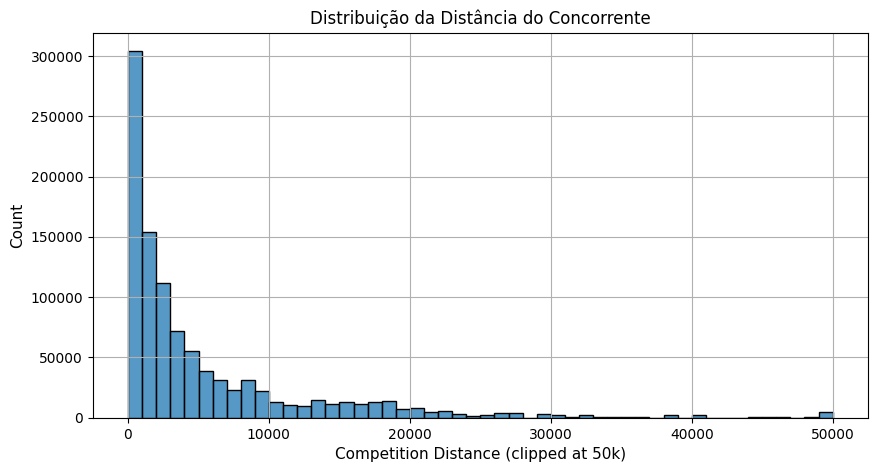

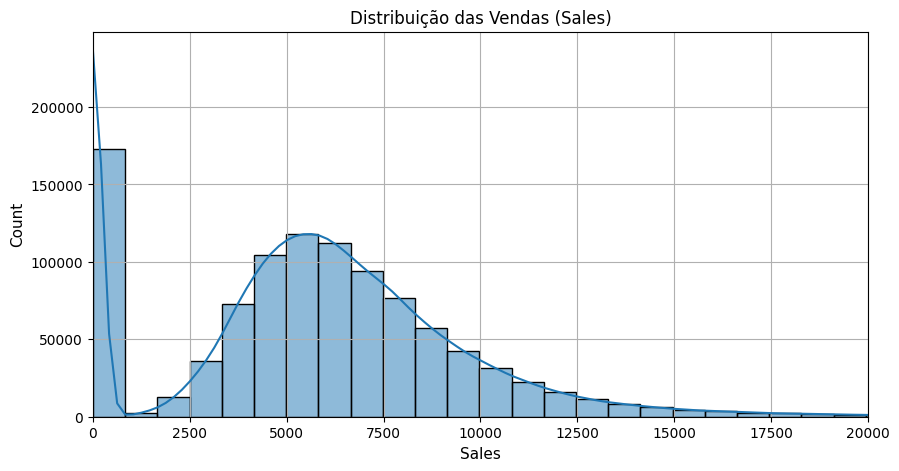

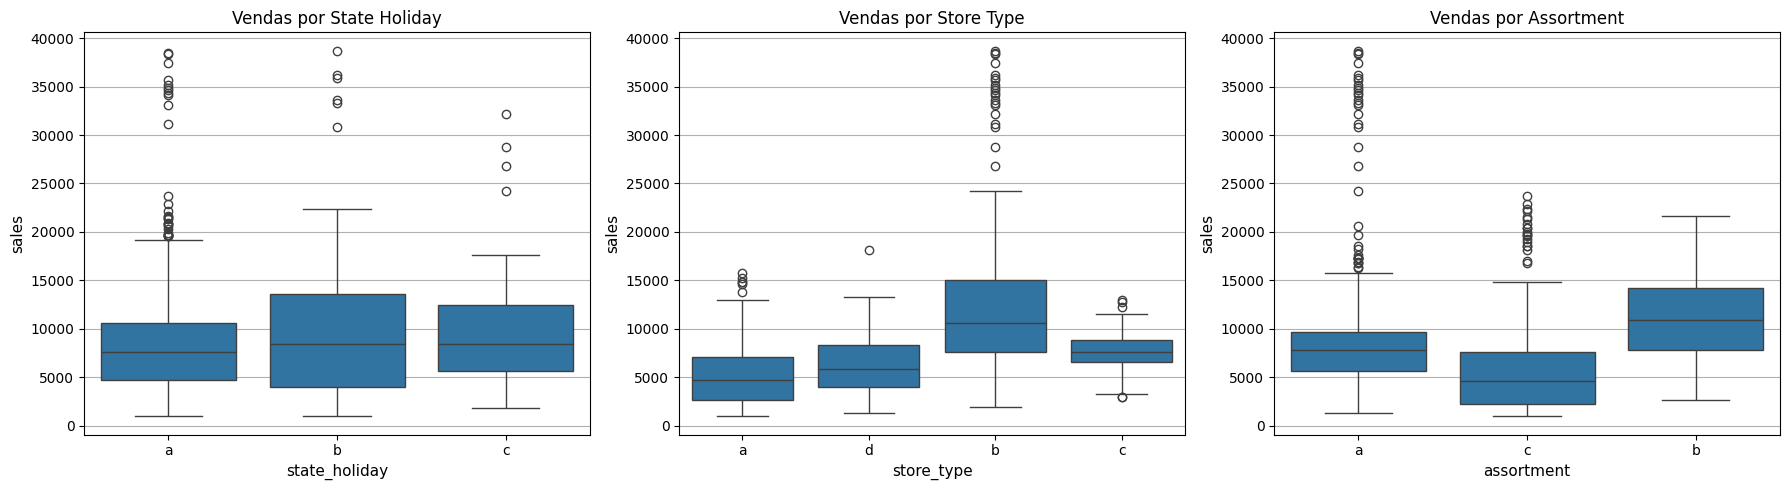

In [16]:
import seaborn as sns

# Distribuição da distância do concorrente (limitando em 50k p/ visualização melhor)
sns.histplot(df1["competition_distance"].clip(upper=50_000), bins=50)
plt.xlabel("Competition Distance (clipped at 50k)")
plt.title("Distribuição da Distância do Concorrente")
plt.show()

# Distribuição de vendas
sns.histplot(df1["sales"], bins=50, kde=True)
plt.xlim(0, 20_000)
plt.title("Distribuição das Vendas (Sales)")
plt.xlabel("Sales")
plt.show()

# Boxplots categóricos (apenas vendas > 0 e feriados != '0')
aux = df1[(df1["state_holiday"] != "0") & (df1["sales"] > 0)]
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
sns.boxplot(x="state_holiday", y="sales", data=aux)
plt.title("Vendas por State Holiday")

plt.subplot(1,3,2)
sns.boxplot(x="store_type", y="sales", data=aux)
plt.title("Vendas por Store Type")

plt.subplot(1,3,3)
sns.boxplot(x="assortment", y="sales", data=aux)
plt.title("Vendas por Assortment")

plt.tight_layout()
plt.show()

# 2.0 Passo 02 — Feature Engineering

In [17]:
df2 = df1.copy()

### Hipóteses são apostas. Exemplos:

* Lojas de maior porte tendem a vender mais.

* Lojas com maior sortimento tendem a vender mais.

## 2.1. Mapa Mental de Hipoteses

![Mapa mental de hipóteses](img/MindMapHypothesis.png)

### 📊 Boxplot (MEDAS):

* Mediana: quem vende mais?

* Espaço da caixa: dispersão (estável/instável?)

* Dados extremos: muitos outliers?

* Assimetria: caixa “pende” para cima ou para baixo?

* Subgrupos: alguma categoria se destaca? Por quê?


### Roteiro mental:

* Fenômeno: o que estou modelando?

* Agentes: quem influencia o fenômeno?

* Atributos dos agentes: quais descrições importam?

* Hipóteses: o que esperar dos dados?

## 2.2. Criação de Hipóteses

### 2.2.1. Hipóteses Loja

**1.** Mais funcionários → mais vendas

**2.** Maior capacidade de estoque → mais vendas

**3.** Maior porte → mais vendas

**4.** Maior sortimento → mais vendas

**5.** Concorrentes próximos → menos vendas

**6.** Concorrência há mais tempo → mais vendas

### 2.2.2. Hipóteses Produto

**1.** Mais marketing → mais vendas

**2.** Maior exposição → mais vendas

**3.** Preços menores → mais vendas

**4.** Promoções mais agressivas → mais vendas

**5.** Promoções ativas por mais tempo → mais vendas

**6.** Mais dias de promoção → mais vendas

**7.** Promoções consecutivas → mais vendas


### 2.2.3. Hipóteses Tempo

**1.** Abertas no Natal → mais vendas

**2.** Tendência de alta ao longo dos anos

**3.** Segundo semestre → mais vendas

**4.** Após dia 10 de cada mês → mais vendas

**5.** Finais de semana → menos vendas

**6.** Feriados escolares → menos vendas

## 2.3. Lista Final de Hipóteses

**1.** Sortimento ↑ → vendas ↑

**2.** Concorrentes próximos → vendas ↓

**3.** Concorrência “antiga” → vendas ↑

**4.** Promoções ativas por mais tempo → vendas ↑

**5.** Mais dias de promoção → vendas ↑

**6.** Promoções consecutivas → vendas ↑

**7.** Abertas no Natal → vendas ↑

**8.** Ao longo dos anos → vendas ↑

**9.** Segundo semestre → vendas ↑

**10.** Depois do dia 10 → vendas ↑

**11.** Finais de semana → vendas ↓

**12.** Feriados escolares → vendas ↓

## 2.4. Feature Engineering

In [18]:
# 2.4 Feature Engineering
df2 = df1.copy()

# --- Calendário básico ---
df2["year"]  = df2["date"].dt.year
df2["month"] = df2["date"].dt.month
df2["day"]   = df2["date"].dt.day

# Semana ISO (UInt32 → int)
df2["week_of_year"] = df2["date"].dt.isocalendar().week.astype(int)

# year_week (ISO year para consistência com a semana ISO)
iso = df2["date"].dt.isocalendar()
df2["iso_year"] = iso.year.astype(int)
df2["year_week"] = df2["iso_year"].astype(str) + "-" + df2["week_of_year"].astype(str).str.zfill(2)

# --- Concorrência: 'competition_since' e tempo em meses ---
# Construir o primeiro dia do mês/ano da abertura do concorrente
comp_year  = df2["competition_open_since_year"].astype("Int64")
comp_month = df2["competition_open_since_month"].astype("Int64")

# Se * Houver NA, .to_timestamp falha; fazemos máscara
mask_comp = comp_year.notna() & comp_month.notna()
df2["competition_since"] = pd.NaT
df2.loc[mask_comp, "competition_since"] = pd.to_datetime(
    comp_year[mask_comp].astype(int).astype(str) + "-" + comp_month[mask_comp].astype(int).astype(str) + "-01",
    errors="coerce"
)

# diferença aproximada em meses (positiva quando já existe concorrência; negativa se anterior)
# fórmula: (ano_diff * 12) + mês_diff
diff_years  = (df2["date"].dt.year - df2["competition_since"].dt.year)
diff_months = (df2["date"].dt.month - df2["competition_since"].dt.month)
df2["competition_time_month"] = (diff_years * 12 + diff_months).astype("Int64")
# Se quiser garantir não-negativo (concorrência ainda não aberta), descomente:
# df2["competition_time_month"] = df2["competition_time_month"].clip(lower=0)

# --- Promo: 'promo_since' e tempo em semanas ---
promo_year = df2["promo2_since_year"].astype("Int64")
promo_week = df2["promo2_since_week"].astype("Int64")

mask_promo = promo_year.notna() & promo_week.notna()
df2["promo_since"] = pd.NaT
# Monday da semana ISO (1 = Monday)
from datetime import date, timedelta
def _iso_week_start(y, w):
    try:
        return pd.Timestamp(date.fromisocalendar(int(y), int(w), 1))
    except Exception:
        return pd.NaT

df2.loc[mask_promo, "promo_since"] = [
    _iso_week_start(y, w) for y, w in zip(promo_year[mask_promo], promo_week[mask_promo])
]

# Se quiser seguir a lógica de alguns cases (voltar 7 dias para alinhar início de campanha):
# df2.loc[mask_promo, "promo_since"] = df2.loc[mask_promo, "promo_since"] - pd.Timedelta(days=7)

# diferença em semanas (arredondando para int)
df2["promo_time_week"] = ((df2["date"] - df2["promo_since"]) / pd.Timedelta(days=7)).astype("float")
df2["promo_time_week"] = df2["promo_time_week"].round(0).astype("Int64")

# --- Mapeamentos semânticos ---
# 'assortment': a=basic, b=extra, c=extended
assort_map = {"a": "basic", "b": "extra", "c": "extended"}
df2["assortment"] = df2["assortment"].map(assort_map).fillna(df2["assortment"])

# 'state_holiday': a=public, b=easter, c=christmas, 0=regular_day
holiday_map = {"a": "public", "b": "easter", "c": "christmas", "0": "regular_day", 0: "regular_day"}
df2["state_holiday"] = df2["state_holiday"].map(holiday_map).fillna("regular_day")

# --- Sazonalidade cíclica (úteis para modelos lineares/árvores) ---
# dia da semana (1..7) e seno/cosseno
df2["day_of_week"] = df2["date"].dt.isocalendar().day.astype(int)  # 1=Mon..7=Sun
df2["day_of_week_sin"] = np.sin(2 * np.pi * df2["day_of_week"] / 7)
df2["day_of_week_cos"] = np.cos(2 * np.pi * df2["day_of_week"] / 7)

df2["month_sin"] = np.sin(2 * np.pi * df2["month"] / 12)
df2["month_cos"] = np.cos(2 * np.pi * df2["month"] / 12)

df2["week_of_year_sin"] = np.sin(2 * np.pi * df2["week_of_year"] / 52)
df2["week_of_year_cos"] = np.cos(2 * np.pi * df2["week_of_year"] / 52)

# --- Flags alinhadas às hipóteses ---
# Natal (semana do Natal): 20–27 de dezembro como janela simples (ajuste à vontade)
df2["is_christmas_week"] = np.where((df2["date"].dt.month == 12) & (df2["date"].dt.day.between(20, 27)), 1, 0)

# Segundo semestre (H2)
df2["is_second_semester"] = np.where(df2["month"] >= 7, 1, 0)

# Depois do dia 10
df2["is_after_day_10"] = np.where(df2["day"] > 10, 1, 0)

# Final de semana (sábado=6, domingo=7 na ISO)
df2["is_weekend"] = np.where(df2["day_of_week"].isin([6, 7]), 1, 0)

# Feriado escolar (já existe a coluna 'school_holiday' 0/1)
df2["is_school_holiday"] = df2["school_holiday"]

# Proximidade de concorrente (transformação log1p ajuda modelos lineares)
df2["competition_distance_log"] = np.log1p(df2["competition_distance"])

# --- Sanidade final ---
expected_new_cols = [
    "year","month","day","week_of_year","year_week","competition_since","competition_time_month",
    "promo_since","promo_time_week","assortment","state_holiday","day_of_week","day_of_week_sin",
    "day_of_week_cos","month_sin","month_cos","week_of_year_sin","week_of_year_cos",
    "is_christmas_week","is_second_semester","is_after_day_10","is_weekend","is_school_holiday",
    "competition_distance_log"
]
print("Novas colunas criadas:", len(expected_new_cols))

Novas colunas criadas: 24


# 3.0 Passo 03 — Filtragem de variáveis

## Filtragem de variáveis x Seleção de variáveis 

- Filtragem de variáveis: restrições de acordo com o negócio

- Seleção de variáveis: variáveis mais relevantes para o modelo

In [19]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [20]:
# Mantém apenas dias em que a loja estava aberta e houve vendas
df3 = df3[(df3["open"] != 0) & (df3["sales"] > 0)]
print(f"Shape após filtro: {df3.shape}")

Shape após filtro: (844338, 42)


## 3.2 Seleção das colunas

In [21]:
# Justificativas:
# - 'customers': fortemente correlacionada com 'sales' (não disponível em previsão futura → vazamento)
# - 'open': já filtrado; não precisamos mais da flag
# - 'promo_interval': já transformado em 'is_promo'
# - 'month_map': auxiliar de transformação, não relevante pro modelo
cols_drop = ["customers", "open", "promo_interval", "month_map"]
df3 = df3.drop(columns=cols_drop, errors="ignore")

print("Colunas removidas:", cols_drop)
print(f"Shape final: {df3.shape}")

Colunas removidas: ['customers', 'open', 'promo_interval', 'month_map']
Shape final: (844338, 38)


### Perguntas para guiar a próxima etapa (feature importance/modelagem):

1. Como cada variável impacta o fenômeno (vendas)?
→ relação esperada: positiva, negativa, ou nula.

2. Qual a força desse impacto?
→ pode ser medida via correlação, estatística de testes, ou importância de features em modelos (árvores, Boruta, SHAP).

### Quais os 3 objetivos da EDA?

* Ganhar experiência de negócio.

* Validar hipoteses de negócios (insights).

* Perceber quais variáveis que são importantes para o modelo.

# 4.0. Passo 04 — Análise Exploratória dos Dados (EDA)

In [22]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável resposta (sales)

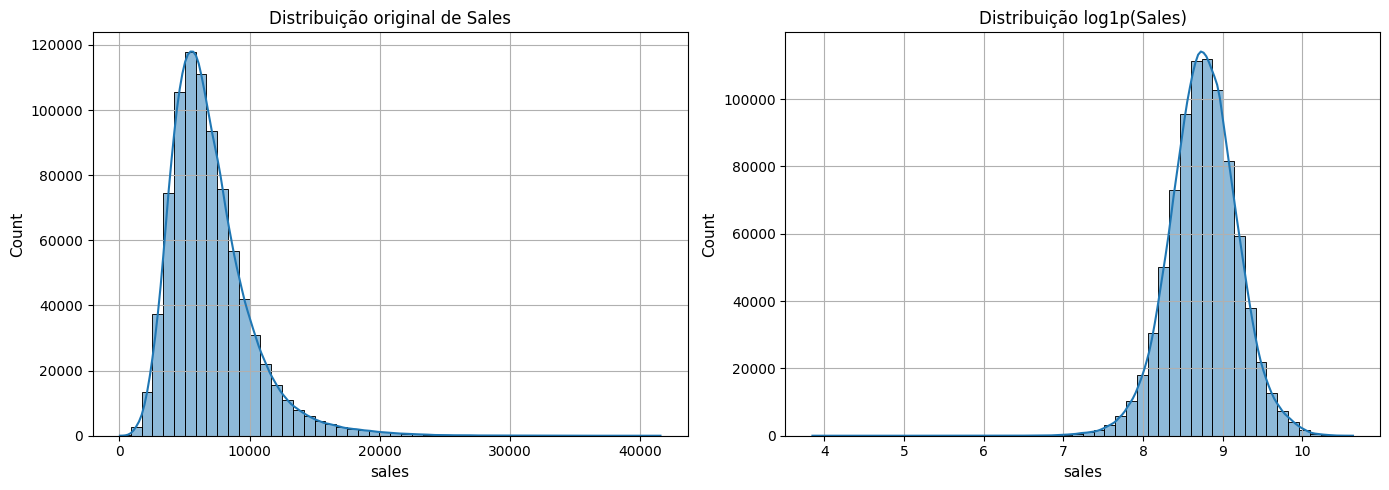

In [23]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.histplot(df4["sales"], bins=50, kde=True)
plt.title("Distribuição original de Sales")

plt.subplot(1,2,2)
sns.histplot(np.log1p(df4["sales"]), bins=50, kde=True)
plt.title("Distribuição log1p(Sales)")

plt.tight_layout()
plt.show()

### 4.1.2 Variáveis numéricas

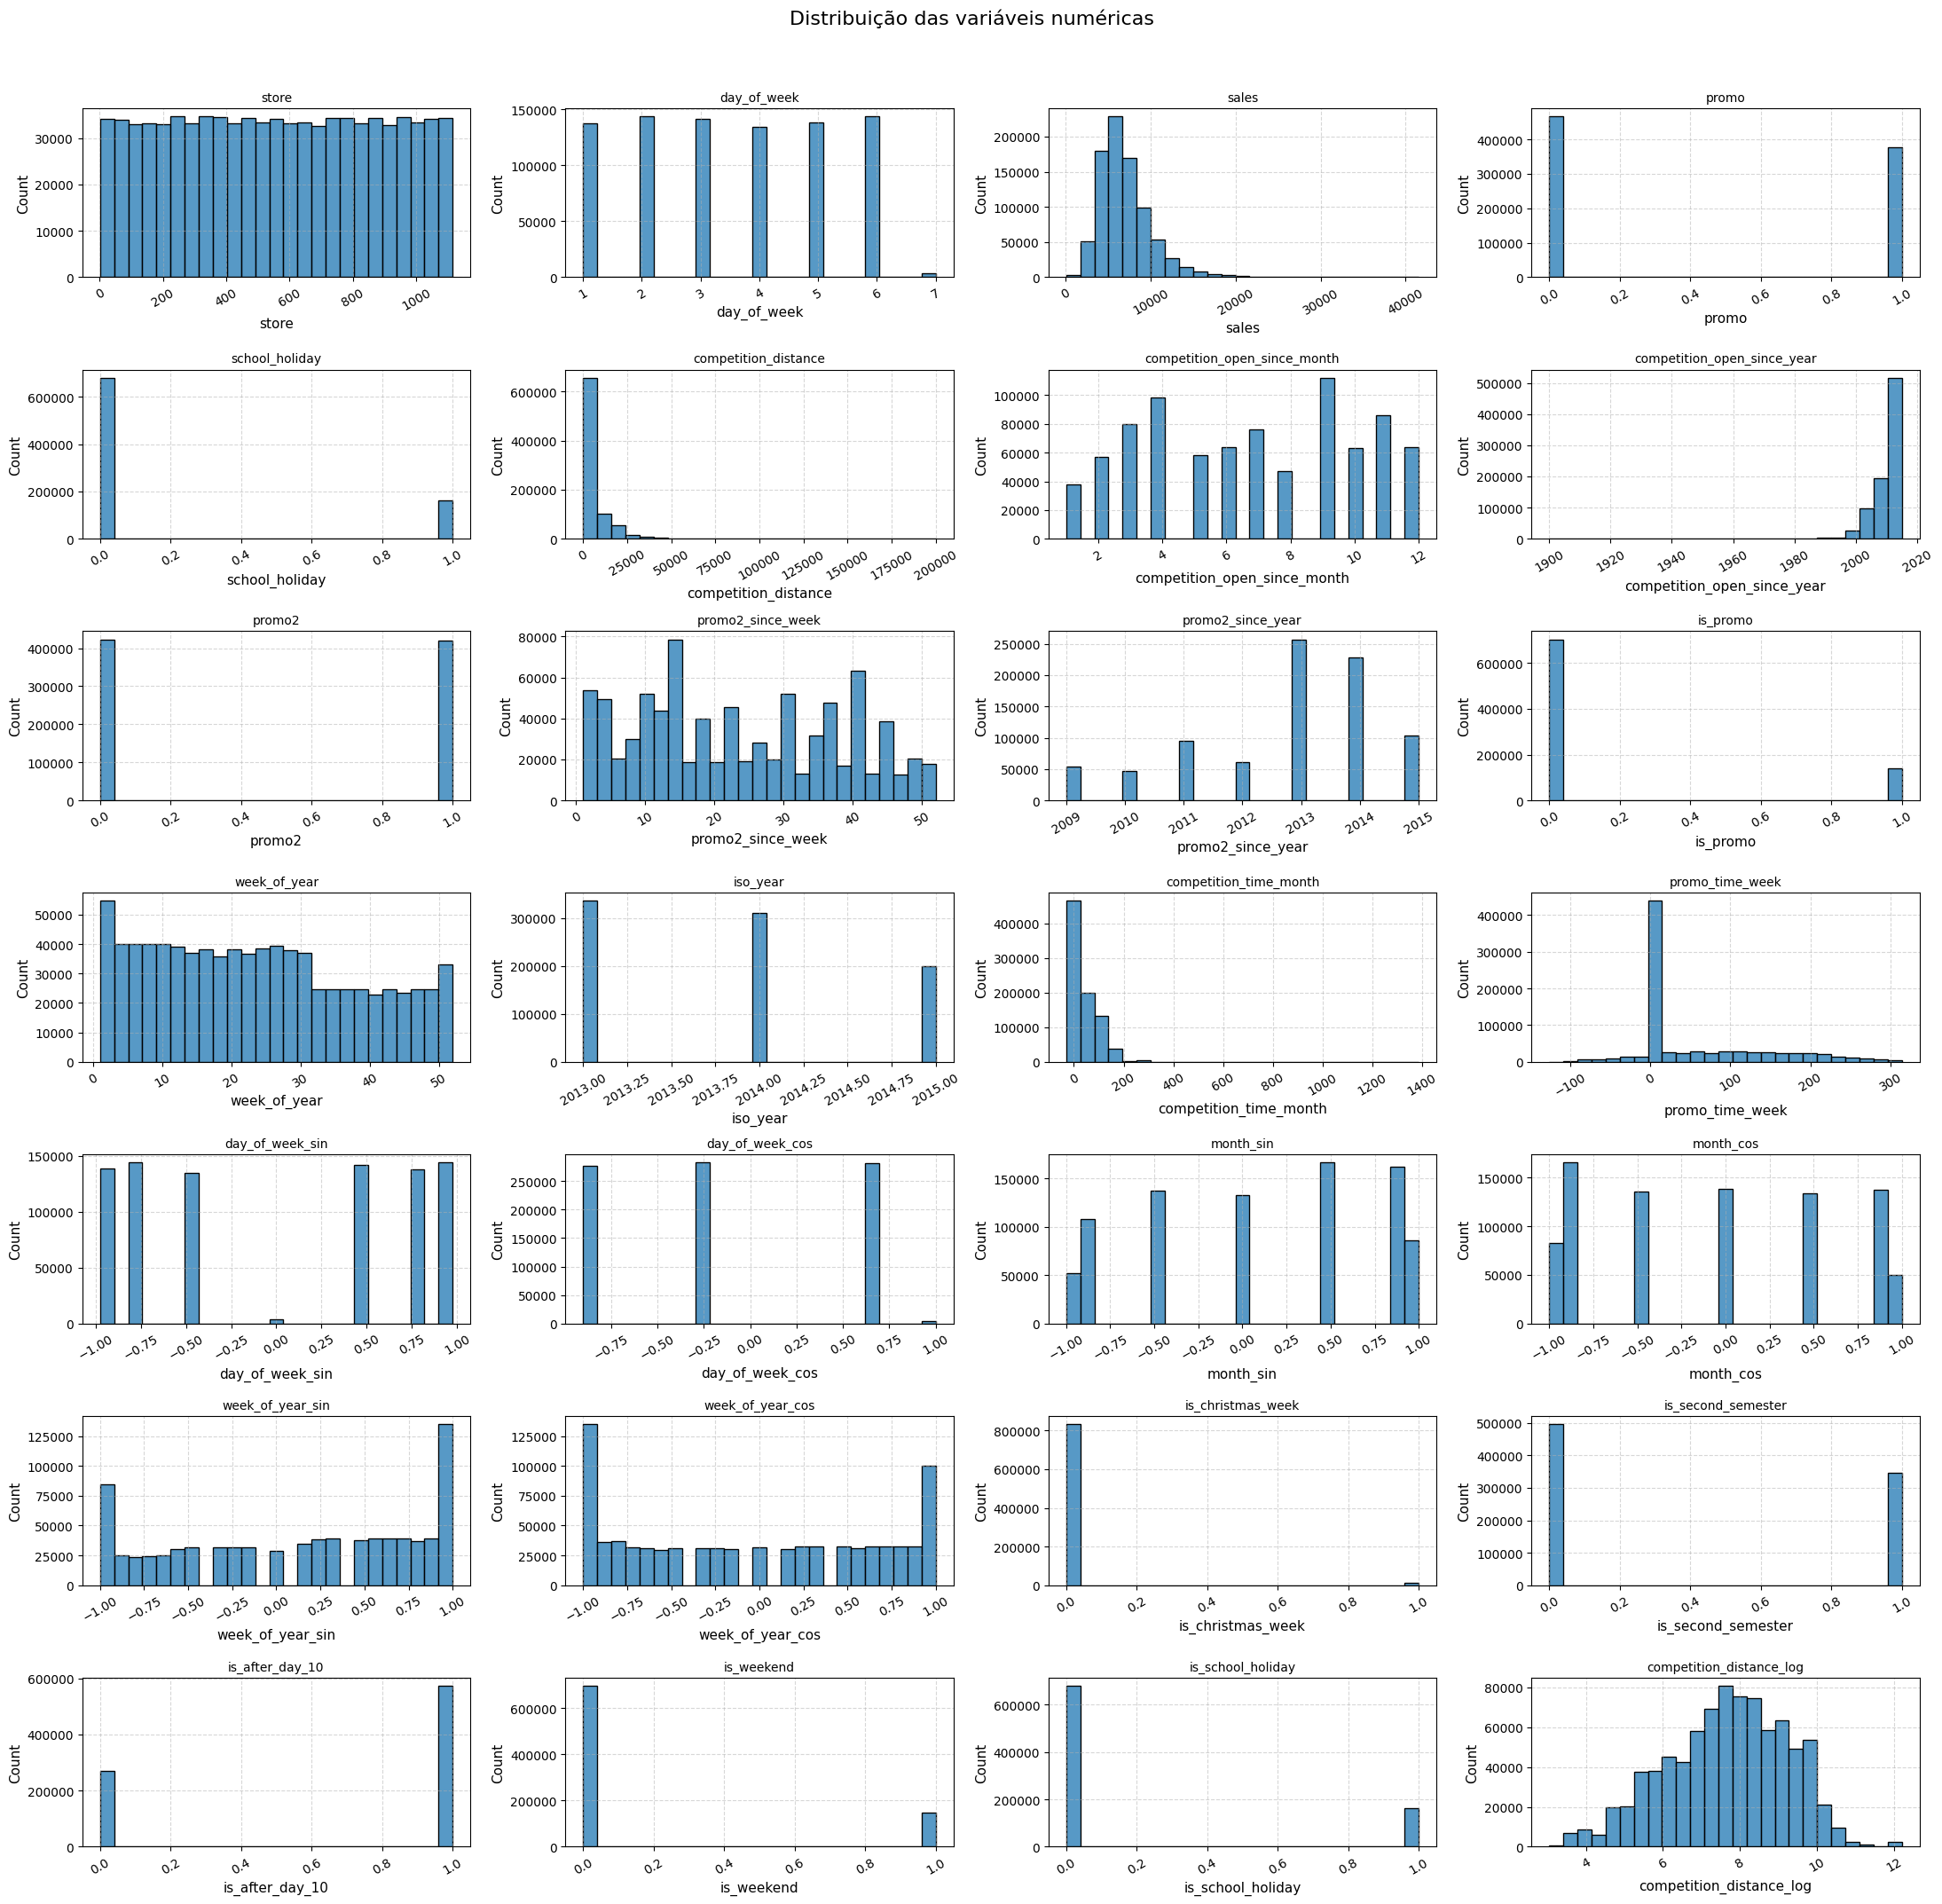

In [24]:
import math

# Seleciona apenas variáveis numéricas
num_attributes = df4.select_dtypes(include=["int64","float64","Int64","Float64"])

# Define layout: nº de linhas e colunas
ncols = 4
nrows = math.ceil(len(num_attributes.columns) / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(22, nrows*3))
axes = axes.flatten()

for i, col in enumerate(num_attributes.columns):
    sns.histplot(num_attributes[col].dropna(), bins=25, ax=axes[i], kde=False)
    axes[i].set_title(col, fontsize=10)
    axes[i].tick_params(axis="x", labelrotation=30)  # rotaciona labels do eixo X para não colar
    axes[i].grid(True, linestyle="--", alpha=0.5)

# remove eixos vazios
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribuição das variáveis numéricas", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### 4.1.3 Variáveis categóricas

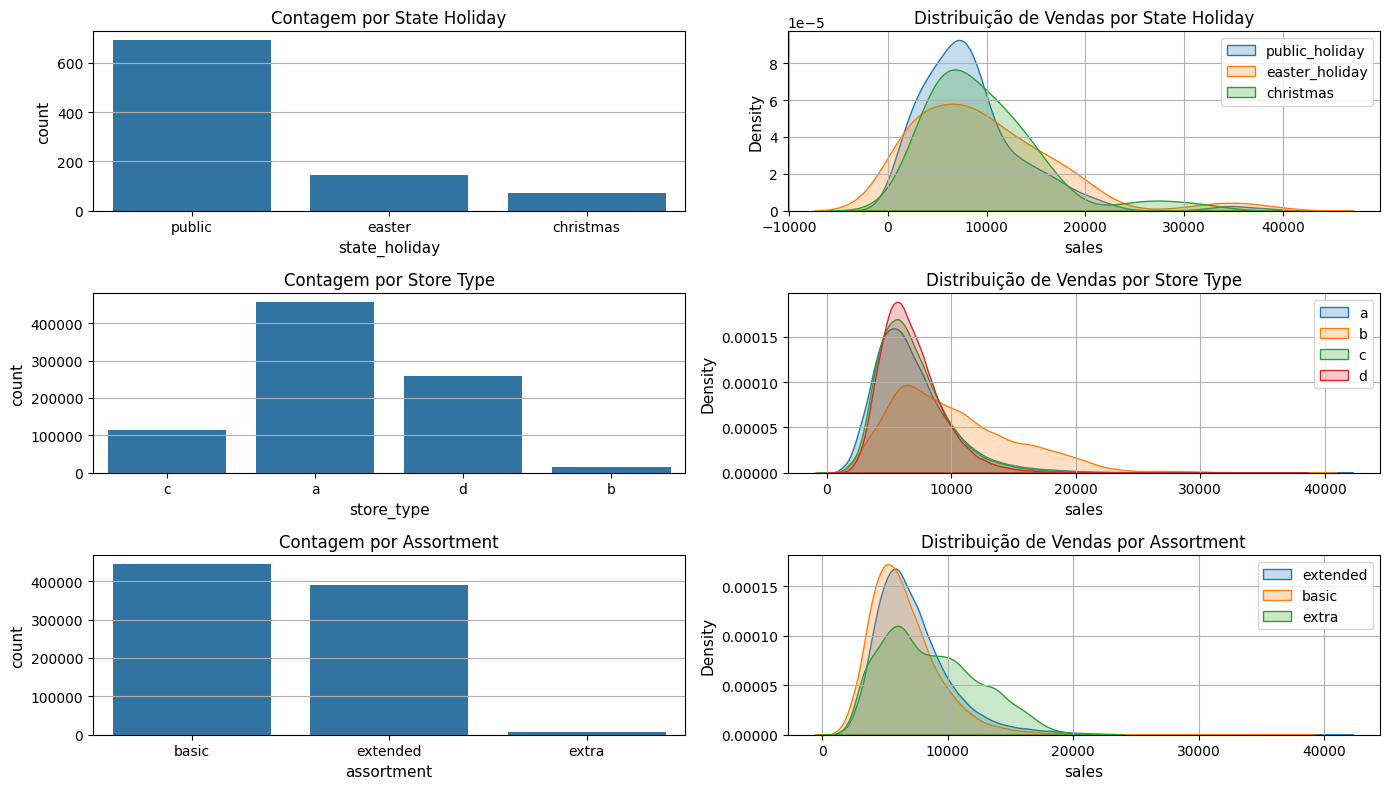

In [25]:
plt.figure(figsize=(14, 8))

# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=a)
plt.title('Contagem por State Holiday')

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
plt.legend()
plt.title('Distribuição de Vendas por State Holiday')

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df4)
plt.title('Contagem por Store Type')

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)
plt.legend()
plt.title('Distribuição de Vendas por Store Type')

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df4)
plt.title('Contagem por Assortment')

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)
plt.legend()
plt.title('Distribuição de Vendas por Assortment')

plt.tight_layout()
plt.show()

## 4.2 Análise Bivariada — Testando Hipóteses

In [26]:
df5 = df4.copy()

### H1. Lojas com maior sortimento deveriam vender mais

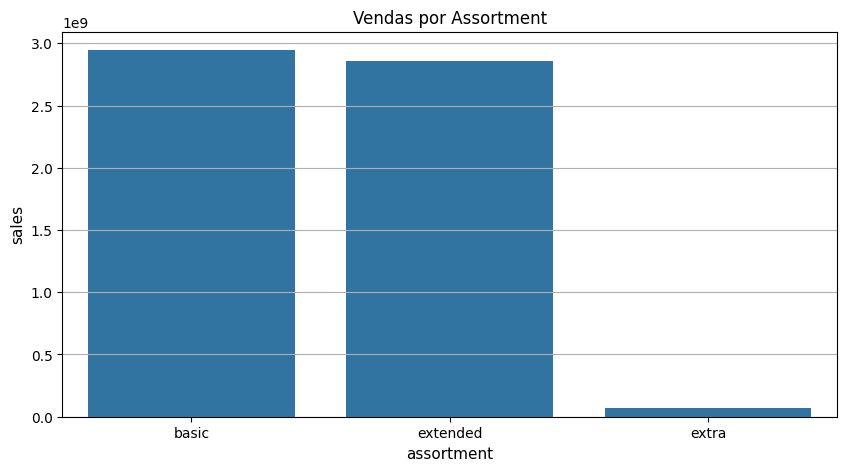

In [27]:
aux = df5.groupby("assortment")["sales"].sum().reset_index()
sns.barplot(x="assortment", y="sales", data=aux)
plt.title("Vendas por Assortment")
plt.show()

📌 Resultado: FALSA. Lojas com extra vendem menos que basic ou extended.

### H2. Lojas com competidores mais próximos deveriam vender menos

C:\Users\bruno.freitas\AppData\Local\Temp\ipykernel_25808\2539583692.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux = df5.groupby("competition_distance_binned")["sales"].sum().reset_index()


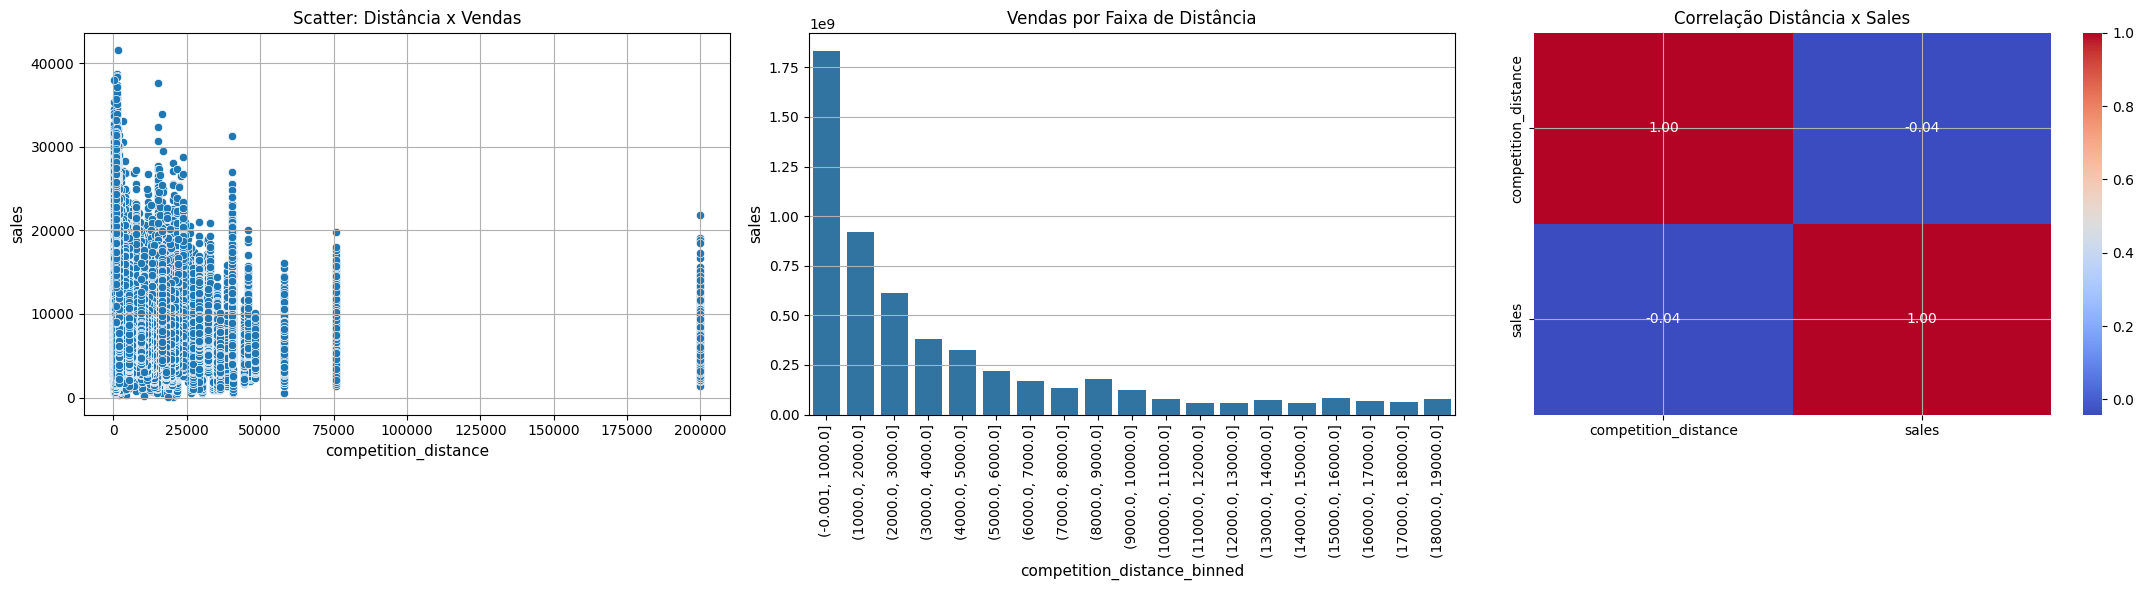

In [28]:
bins = np.arange(0, 20000, 1000)
df5["competition_distance_binned"] = pd.cut(df5["competition_distance"], bins=bins, include_lowest=True)

fig, axes = plt.subplots(1,3,figsize=(22,6))
sns.scatterplot(x="competition_distance", y="sales", data=df5, ax=axes[0])
axes[0].set_title("Scatter: Distância x Vendas")

aux = df5.groupby("competition_distance_binned")["sales"].sum().reset_index()
sns.barplot(x="competition_distance_binned", y="sales", data=aux, ax=axes[1])
axes[1].tick_params(axis="x", rotation=90)
axes[1].set_title("Vendas por Faixa de Distância")

sns.heatmap(df5[["competition_distance","sales"]].corr(), annot=True, cmap="coolwarm", fmt=".2f", ax=axes[2])
axes[2].set_title("Correlação Distância x Sales")
plt.tight_layout()
plt.show()

📌 Resultado: FALSA. Quanto mais próximos, mais vendem.

### H3. Lojas com competidores há mais tempo deveriam vender mais

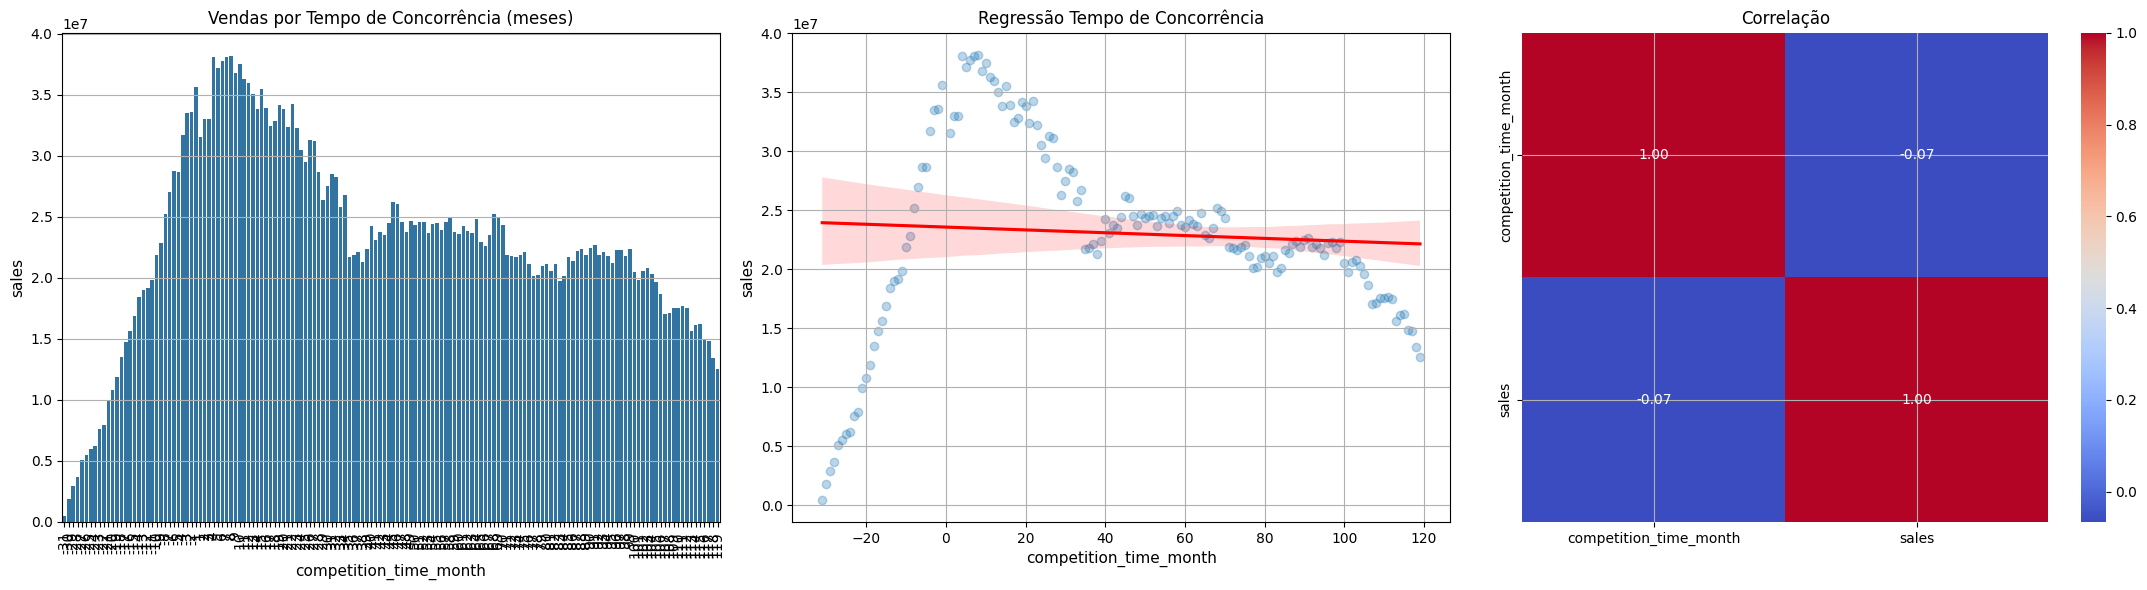

In [29]:
aux = df5.groupby("competition_time_month")["sales"].sum().reset_index()
aux = aux[(aux["competition_time_month"] < 120) & (aux["competition_time_month"] != 0)]

fig, axes = plt.subplots(1,3,figsize=(22,6))
sns.barplot(x="competition_time_month", y="sales", data=aux, ax=axes[0])
axes[0].set_title("Vendas por Tempo de Concorrência (meses)")
axes[0].tick_params(axis="x", rotation=90)

sns.regplot(x="competition_time_month", y="sales", data=aux, scatter_kws={"alpha":0.3}, line_kws={"color":"red"}, ax=axes[1])
axes[1].set_title("Regressão Tempo de Concorrência")

sns.heatmap(aux.corr(), annot=True, cmap="coolwarm", fmt=".2f", ax=axes[2])
axes[2].set_title("Correlação")
plt.tight_layout()
plt.show()


📌 Resultado: FALSA. Quanto mais tempo de concorrência, menos vendem.

### H4. Lojas com promoções por mais tempo deveriam vender mais

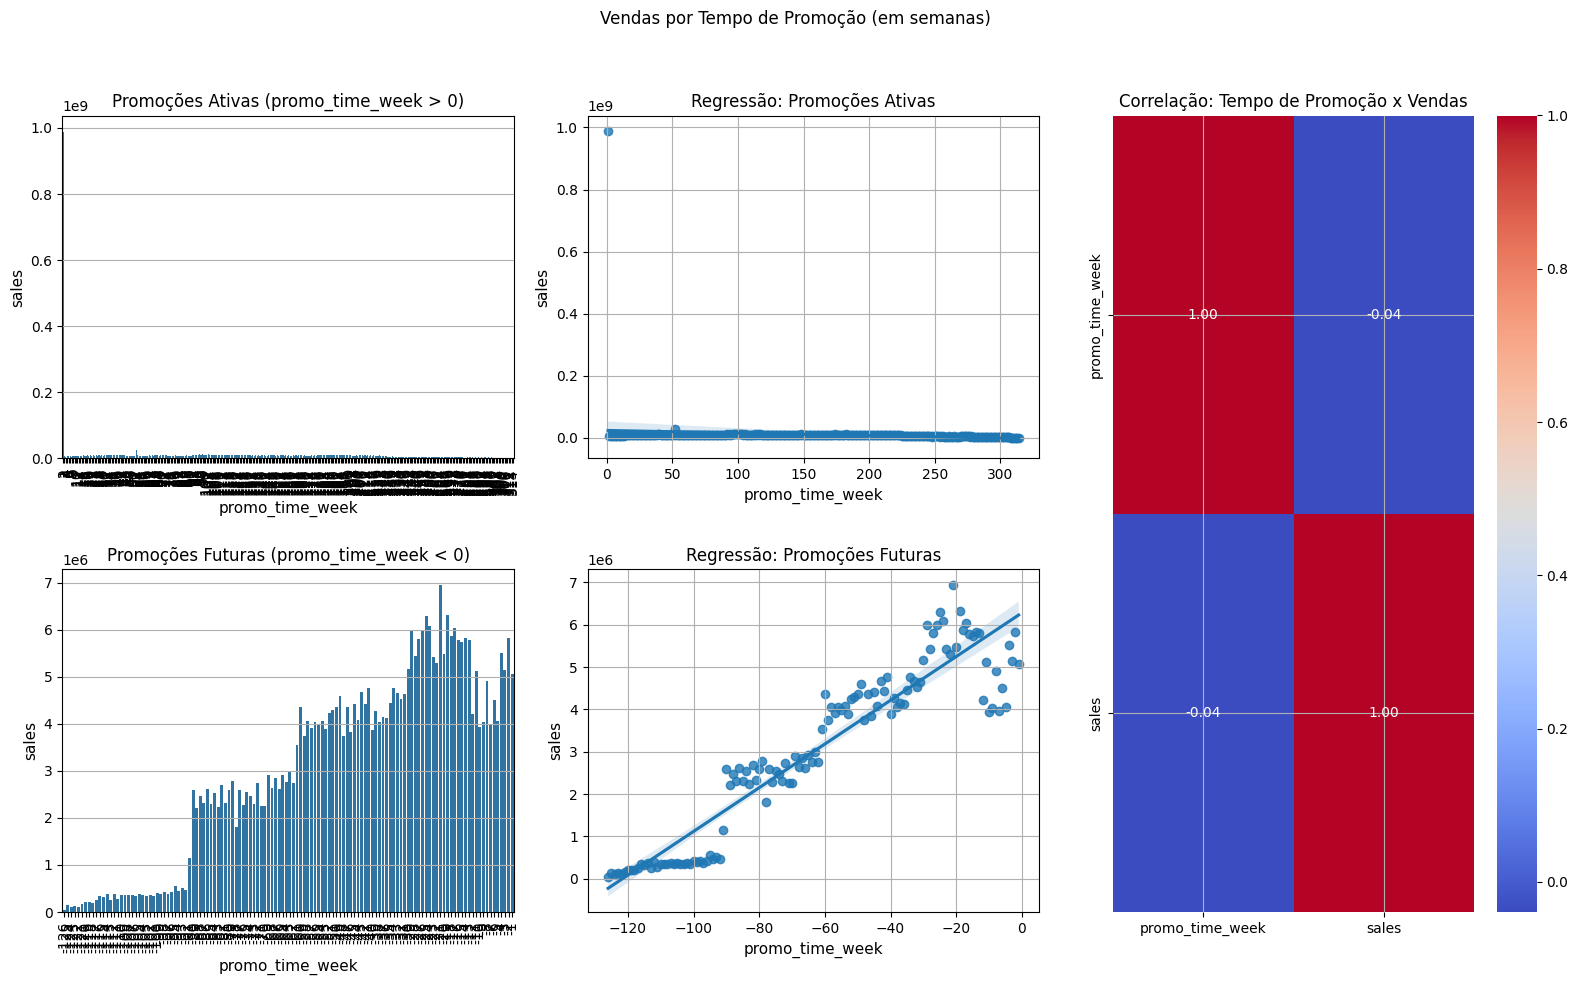

In [30]:
from matplotlib.gridspec import GridSpec
import seaborn as sns
import matplotlib.pyplot as plt

aux1 = df5[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

fig = plt.figure(figsize=(16, 10))
plt.suptitle('Vendas por Tempo de Promoção (em semanas)')

grid = GridSpec(nrows=2, ncols=3, figure=fig)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.title('Promoções Ativas (promo_time_week > 0)')
plt.xticks(rotation=90)

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)
plt.title('Regressão: Promoções Ativas')

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.title('Promoções Futuras (promo_time_week < 0)')
plt.xticks(rotation=90)

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)
plt.title('Regressão: Promoções Futuras')

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação: Tempo de Promoção x Vendas')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### **H6.** Loja com mais promoções consecutivas deveriam vender mais

**Falso** Lojas com mais promoções consecutivas VENDEM MENOS.

In [31]:
df5[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


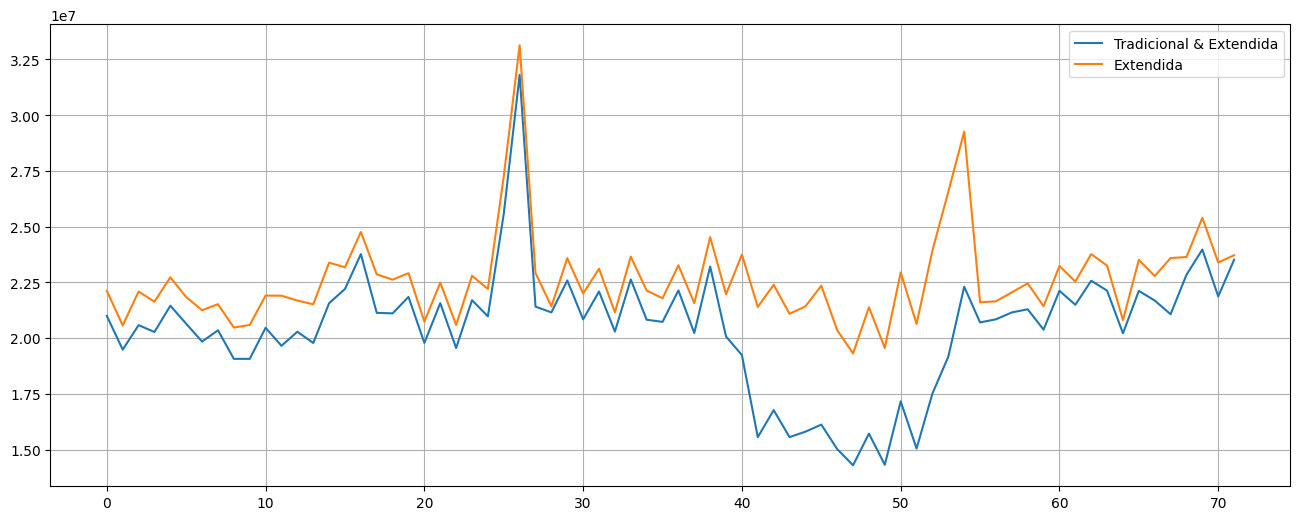

In [32]:
aux1 = df5[(df5['promo'] == 1) & (df5['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(kind='line', figsize=(16, 6))

aux2 = df5[(df5['promo'] == 1) & (df5['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(kind='line', figsize=(16, 6), ax=ax)

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### **H7.** Loja abertas durante o feriado de Natal deveriam vender mais

**Falso** Lojas abertas durante o feriado de natal vendem menos

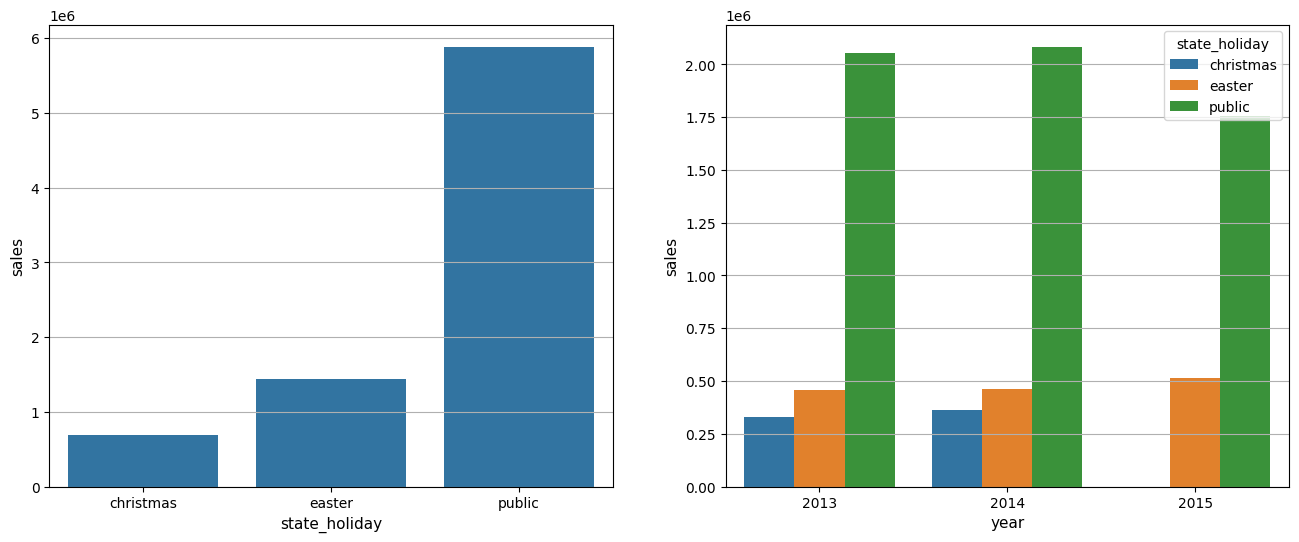

In [33]:
aux = df5[df5['state_holiday'] != 'regular_day'] # Retirando os dias normais para melhor visualização

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H8.** Loja deveriam vender mais ao longo dos anos

**Falso** Lojas vendem MENOS ao longo dos anos

<Axes: >

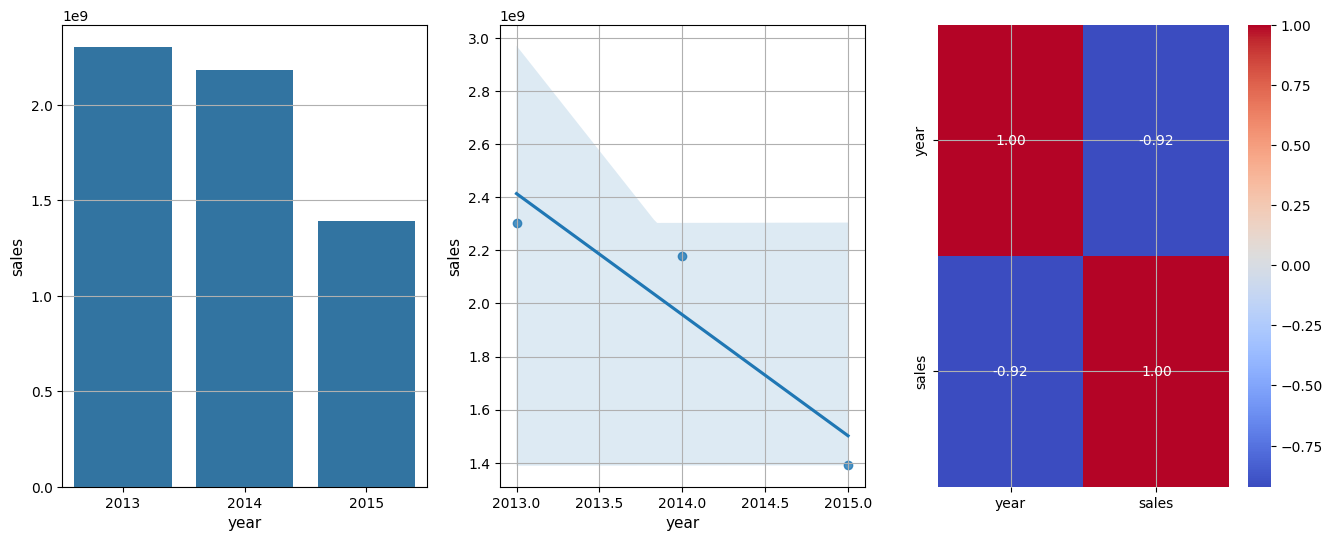

In [34]:
aux1 = df5[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f')

### **H9.** Loja deveriam vender mais no segundo semestre do ano

**FALSO** Lojas vendem MENOS no segundo semestre do ano

<Axes: >

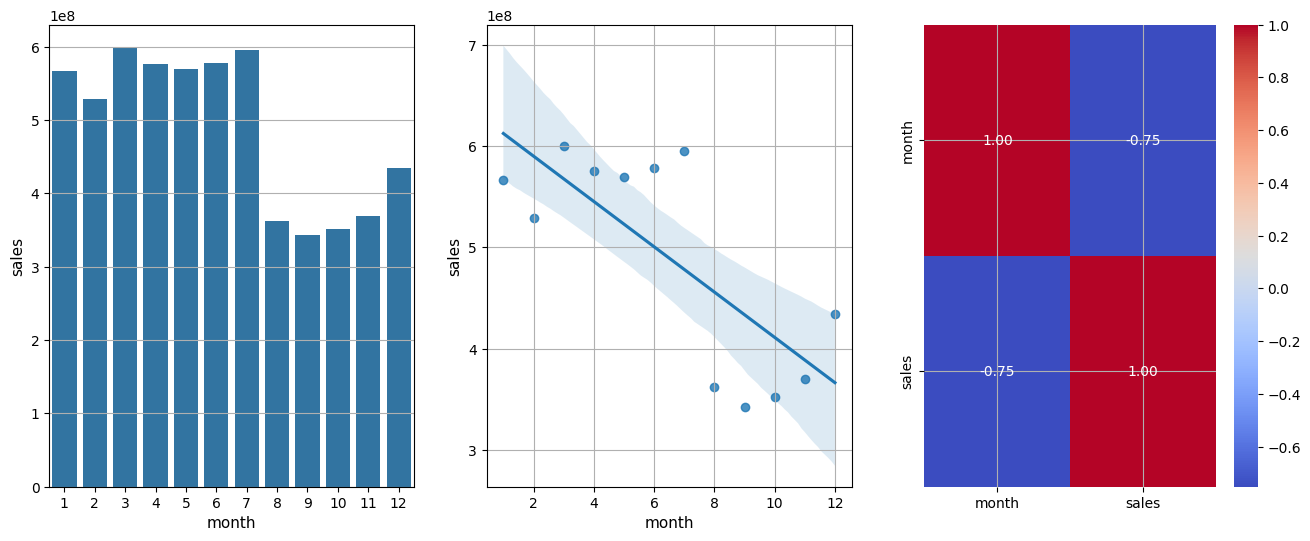

In [35]:
aux1 = df5[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f')

### **H10.** Loja deveriam vender mais depois do dia 10 de cada mês

**Verdadeira** Lojas vendem mais depois do dia 10 de cada mês 

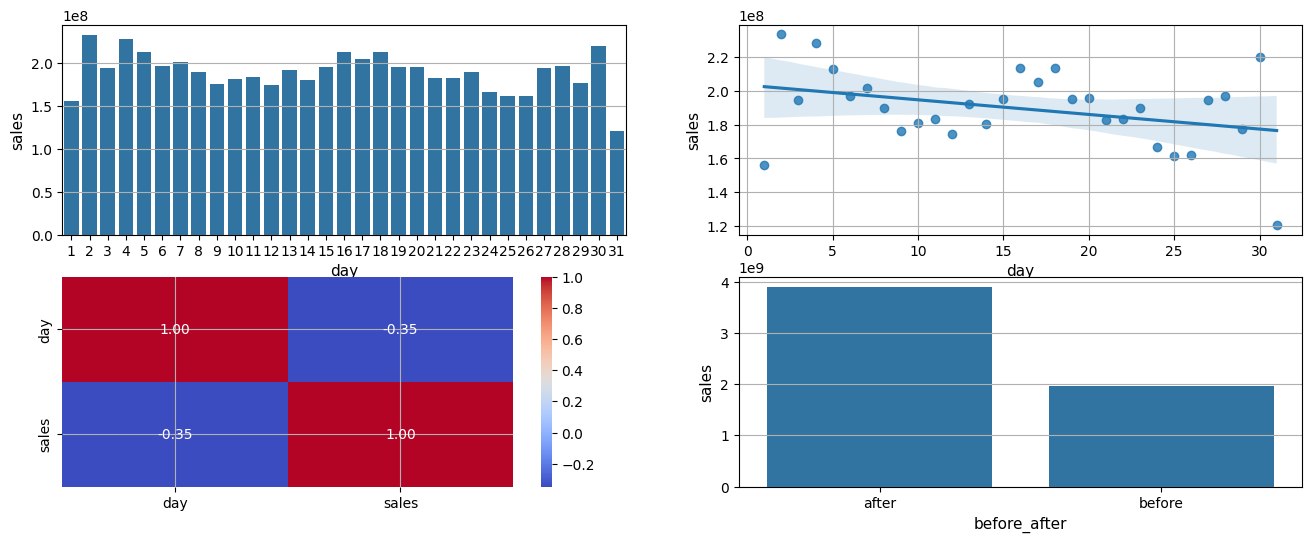

In [36]:
aux1 = df5[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(16, 6))

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f')

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before' if x <= 10 else 'after')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### **H11.** Loja deveriam vender menos aos finais de semana

**Verdadeiro** Lojas vendem MENOS nos finais de semana

<Axes: >

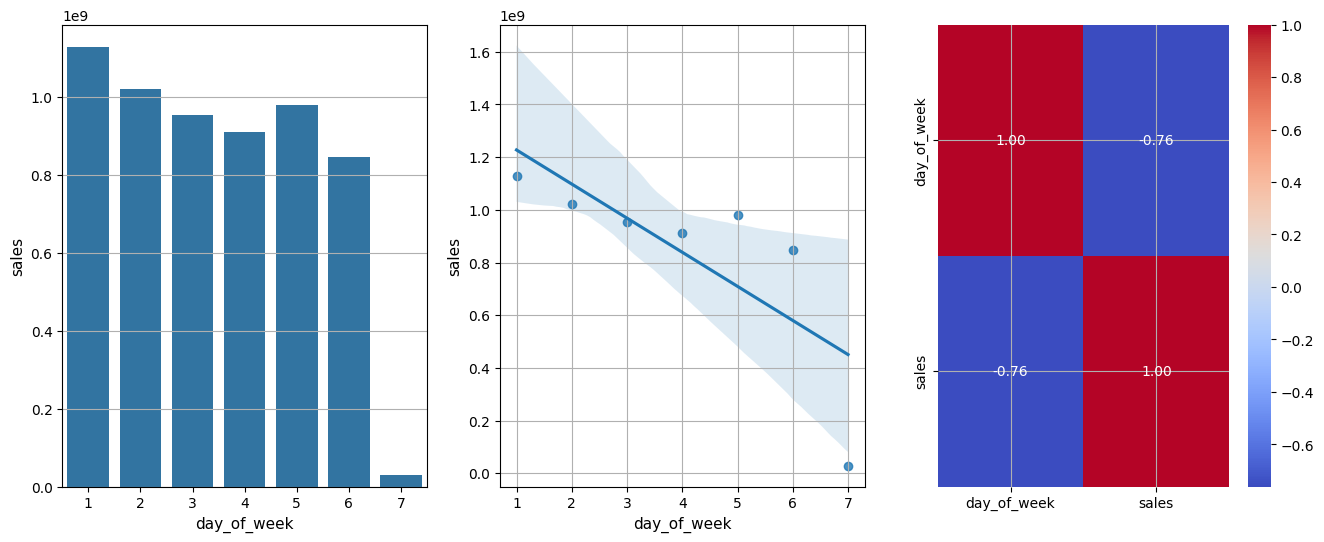

In [37]:
aux1 = df5[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f')

### **H12.** Loja deveriam vender menos durante os feriados escolares

**Verdadeira** Lojas vendem menos durante os feriados escolares, exceto nos meses de julho e agosto.

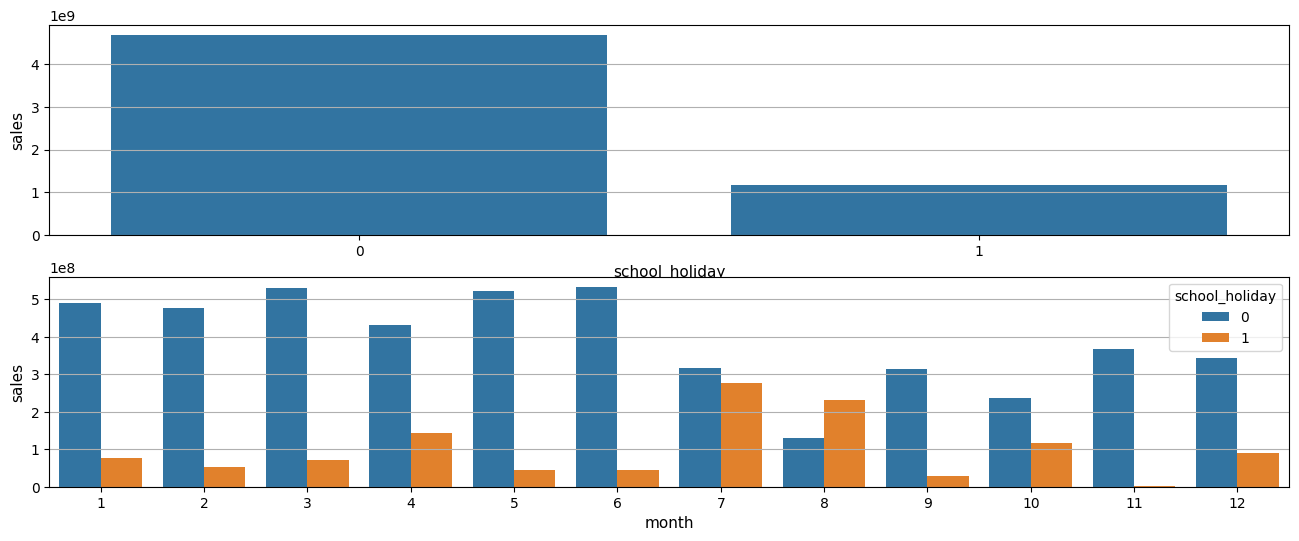

In [38]:
plt.figure(figsize=(16, 6))

plt.subplot(2, 1, 1)
aux1 = df5[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(2, 1, 2)
aux2 = df5[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

# plt.subplot(1, 3, 3)
# sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f')

In [39]:
from tabulate import tabulate

tab = [
    ["Hipótese","Conclusão","Relevância"],
    ["H1","Falsa","Baixa"],
    ["H2","Falsa","Média"],
    ["H3","Falsa","Média"],
    ["H4","Falsa","Baixa"],
    ["H5","--","--"],
    ["H6","Falsa","Baixa"],
    ["H7","Falsa","Média"],
    ["H8","Falsa","Alta"],
    ["H9","Falsa","Alta"],
    ["H10","Verdadeira","Alta"],
    ["H11","Verdadeira","Alta"],
    ["H12","Verdadeira","Baixa"],
]

print(tabulate(tab, headers="firstrow", tablefmt="grid", stralign="center"))


+------------+-------------+--------------+
|  Hipótese  |  Conclusão  |  Relevância  |
+============+=============+==============+
|     H1     |    Falsa    |    Baixa     |
+------------+-------------+--------------+
|     H2     |    Falsa    |    Média     |
+------------+-------------+--------------+
|     H3     |    Falsa    |    Média     |
+------------+-------------+--------------+
|     H4     |    Falsa    |    Baixa     |
+------------+-------------+--------------+
|     H5     |     --      |      --      |
+------------+-------------+--------------+
|     H6     |    Falsa    |    Baixa     |
+------------+-------------+--------------+
|     H7     |    Falsa    |    Média     |
+------------+-------------+--------------+
|     H8     |    Falsa    |     Alta     |
+------------+-------------+--------------+
|     H9     |    Falsa    |     Alta     |
+------------+-------------+--------------+
|    H10     | Verdadeira  |     Alta     |
+------------+-------------+----

## 4.3 Análise Multivariada

### 4.3.1 Numéricas

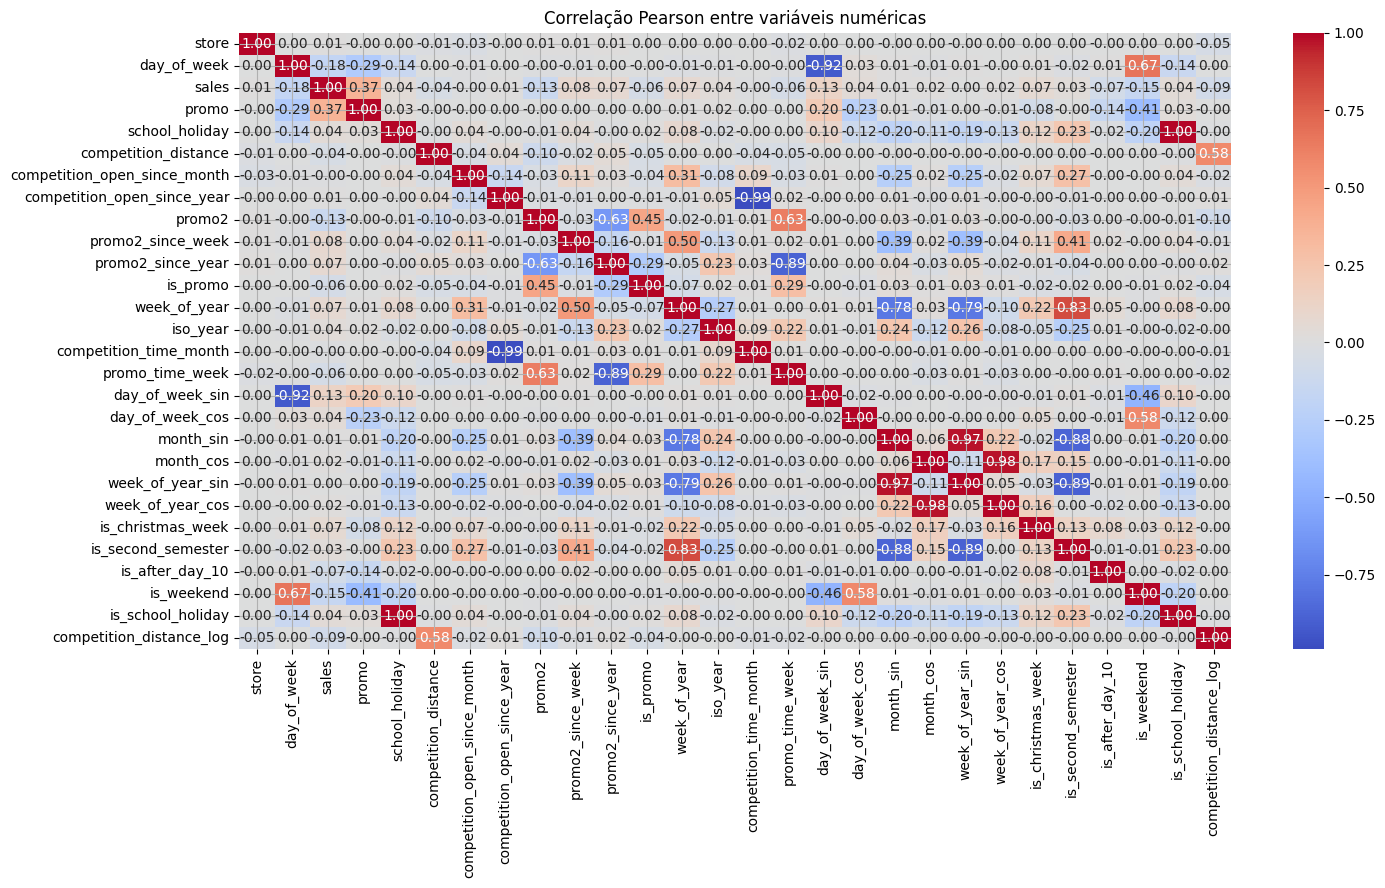

In [40]:
correlation = df5.select_dtypes(include=["int64","float64","Int64"]).corr(method="pearson")
plt.figure(figsize=(16,8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlação Pearson entre variáveis numéricas")
plt.show()

### 4.3.2 Categóricas (Cramér's V)

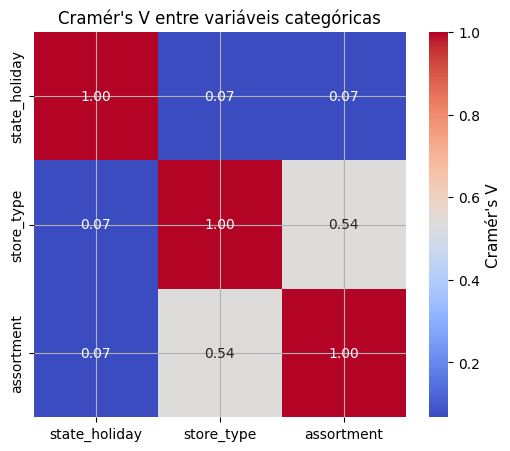

In [41]:
cats = ["state_holiday","store_type","assortment"]
matrix = pd.DataFrame(index=cats, columns=cats, dtype=float)

for i in cats:
    for j in cats:
        matrix.loc[i,j] = cramers_v(df5[i], df5[j])

plt.figure(figsize=(6,5))
sns.heatmap(matrix.astype(float), annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label":"Cramér's V"})
plt.title("Cramér's V entre variáveis categóricas")
plt.show()

In [42]:
df5 = df4.copy()

Como a variável impacta na resposta?

# 5.0. Passo 05 - Preparação e Modelagem dos Dados

* Motivação: O aprendizado da maioria dos algoritmos de ML é facilitado com dados numéricos, na mesma escala.

1. Categóricas para numéricas (Enconding)

2. Redistribuição dos dados (padronizar ou normalizar)

In [55]:
df6 = df5.copy()

## 5.1 Normalização (quando útil)

* Não aplicamos normalização padronizada (z-score) aqui,
* pois variáveis de tempo e contagem fazem mais sentido em escala robusta ou [0,1].


## 5.2. Rescaling

In [56]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

rs = RobustScaler()
mms = MinMaxScaler()

In [57]:
# Usamos RobustScaler para variáveis com muitos outliers (competition, tempo).
df6["competition_distance"]    = rs.fit_transform(df6[["competition_distance"]])
df6["competition_time_month"]  = rs.fit_transform(df6[["competition_time_month"]])

# Usamos MinMaxScaler para variáveis mais regulares/limitadas.
df6["promo_time_week"]         = mms.fit_transform(df6[["promo_time_week"]])
df6["year"]                    = mms.fit_transform(df6[["year"]])

# Obs: idealmente, salvar scalers com pickle/joblib para reproduzir em produção.
# Exemplo: pickle.dump(rs, open("parameter/competition_distance_scaler.pkl", "wb"))

## 5.3. Transformação

In [58]:
from sklearn.preprocessing import LabelEncoder

### 5.3.1 Enconding

In [59]:
# state_holiday - One Hot Encoding
df6 = pd.get_dummies(df6, columns=["state_holiday"], prefix="state_holiday")

# store_type - Label Encoding
le = LabelEncoder()
df6["store_type"] = le.fit_transform(df6["store_type"])

# assortment - Ordinal Encoding
assortment_dict = {"basic": 1, "extra": 2, "extended": 3}
df6["assortment"] = df6["assortment"].map(assortment_dict)

### 5.3.2 Response Variable Transformation

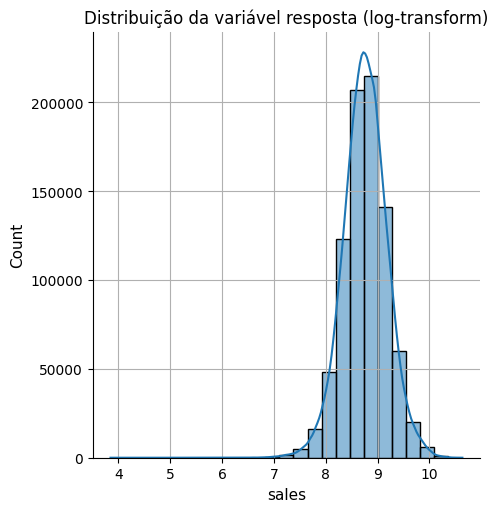

In [60]:
# Log-transform em Sales para reduzir assimetria
df6["sales"] = np.log1p(df6["sales"])

sns.displot(df6["sales"], bins=25, kde=True)
plt.title("Distribuição da variável resposta (log-transform)", fontsize=12)
plt.show()

### 5.3.3 Nature Transformation (cíclicas)

In [61]:
# ------------------------------------------------------
# Dia da semana
df6["day_of_week_sin"] = np.sin(df6["day_of_week"] * (2 * np.pi / 7))
df6["day_of_week_cos"] = np.cos(df6["day_of_week"] * (2 * np.pi / 7))

# Semana do ano
df6["week_of_year_sin"] = np.sin(df6["week_of_year"] * (2 * np.pi / 52))
df6["week_of_year_cos"] = np.cos(df6["week_of_year"] * (2 * np.pi / 52))

# Mês
df6["month_sin"] = np.sin(df6["month"] * (2 * np.pi / 12))
df6["month_cos"] = np.cos(df6["month"] * (2 * np.pi / 12))

# Dia do mês
df6["day_sin"] = np.sin(df6["day"] * (2 * np.pi / 30))
df6["day_cos"] = np.cos(df6["day"] * (2 * np.pi / 30))

print("Shape final após preparação:", df6.shape)

Shape final após preparação: (844338, 44)


# 6.0: Seleção de variáveis (Feature Selection)

Princípio: comece simples, elimine o que é redundante/inútil, valide a relevância no tempo (sem shuffles aleatórios).

In [62]:
df_sel = df6.copy()

## 6.1. Split dataframe into training and test dataset

In [63]:
# Remova artefatos que não vão ao modelo
drop_cols = [
    # ids/tempo “cru” ou auxiliares
    "date", "year_week", "competition_since", "promo_since",
    "day", "month", "week_of_year", "day_of_week",
    # colunas criadas só para EDA
    "competition_distance_binned"
]
df_sel = df_sel.drop(columns=[c for c in drop_cols if c in df_sel.columns], errors="ignore")

In [64]:
TARGET = "sales"

# Split temporal estático (alinha com nosso splitter: val_start=2015-06-20)
CUTOFF_DATE = pd.Timestamp("2015-06-19")

train_mask = df6["date"] < CUTOFF_DATE
test_mask  = df6["date"] >= CUTOFF_DATE

X_train = df_sel.loc[train_mask].drop(columns=[TARGET])
y_train = df_sel.loc[train_mask, TARGET]

X_test  = df_sel.loc[test_mask].drop(columns=[TARGET])
y_test  = df_sel.loc[test_mask, TARGET]

print("Train:", X_train.shape, "| Test:", X_test.shape)

Train: (802942, 34) | Test: (41396, 34)


## 6.2. Boruta as Feature Selector

In [65]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd

### 6.2.1 Remover quase-constantes (baixa variância)

In [66]:
vt = VarianceThreshold(threshold=1e-8)
vt.fit(X_train)
keep_mask = vt.get_support()
X_train_f = X_train.loc[:, keep_mask]
X_test_f  = X_test.loc[:, keep_mask]

### 6.2.2 Remover colinearidade forte (|corr| >= 0.95)

In [67]:
corr = X_train_f.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop_corr = [col for col in upper.columns if any(upper[col] >= 0.95)]

X_train_f = X_train_f.drop(columns=to_drop_corr, errors="ignore")
X_test_f  = X_test_f.drop(columns=to_drop_corr, errors="ignore")

print("Após filtros:", X_train_f.shape, "| removidos por correlação:", len(to_drop_corr))


Após filtros: (802942, 29) | removidos por correlação: 5


## 6.3 Importância por permutação (com split temporal)

Vantagens: rápida, estável e avalia impacto real na métrica sem re-treinar mil vezes.

In [68]:
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

In [69]:
# Modelo leve (pode trocar por RandomForestRegressor se preferir)
model_fs = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

In [70]:
# Treina no treino (passado)
model_fs.fit(X_train_f, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=-1, num_parallel_tree=None, ...)

In [72]:
# === Permutation Importance: versão robusta (evita TerminatedWorkerError) ===
import gc
from sklearn.inspection import permutation_importance

# 1) Reduz consumo de memória
X_train_f = X_train_f.astype("float32", copy=False)
X_test_f  = X_test_f.astype("float32",  copy=False)

# 2) Subamostra do TESTE para a importância (mantém ordem temporal por índice)
MAX_PI_ROWS = 200_000  # ajuste se quiser
if len(X_test_f) > MAX_PI_ROWS:
    # amostra estratificada não é necessária aqui; só amostramos por tamanho
    X_pi = X_test_f.sample(n=MAX_PI_ROWS, random_state=42)
    y_pi = y_test.loc[X_pi.index]
else:
    X_pi = X_test_f
    y_pi = y_test

# 3) Modelo sem paralelismo interno (evita conflito com joblib)
model_fs.set_params(n_jobs=1)

# 4) Importância por permutação SEM paralelismo e com menos repetições
#    (max_samples<1.0 faz a função subamostrar a cada repetição, reduzindo ainda mais o custo)
pi = permutation_importance(
    model_fs,
    X_pi, y_pi,
    scoring="neg_mean_absolute_error",
    n_repeats=5,            # era 10; reduzi para estabilizar
    random_state=42,
    n_jobs=1,               # <<< serial para não estourar memória
    max_samples=0.5         # usa 50% dos X_pi em cada repetição
)


In [73]:
# 5) Monta o DataFrame de importâncias
pi_df = (
    pd.DataFrame({
        "feature": X_pi.columns,
        "importance": pi.importances_mean,
        "std": pi.importances_std
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

del X_pi, y_pi; gc.collect()

2638

In [74]:
pi_df.head(20)

,feature,importance,std
0,promo,0.083748,0.000935
1,competition_distance,0.080641,0.000964
2,store,0.065069,0.000208
3,assortment,0.040425,0.000204
4,competition_open_since_year,0.034096,0.000548
5,competition_open_since_month,0.023921,0.000271
6,store_type,0.022112,0.000387
7,promo2,0.017720,0.000313
8,promo2_since_year,0.015091,0.000385
9,day_of_week_cos,0.014792,0.000122


## 6.4 Seleção final orientada a desempenho

Regra simples e eficaz: mantenha as features com importância ≥ 0 (ou um “joelho” visual). Depois valide com backtesting.

In [75]:
# Mantém variáveis com importância média positiva (ganho de MAE ao permutar)
selected_mask = pi_df["importance"] > 0
cols_selected_pi = pi_df.loc[selected_mask, "feature"].tolist()

# Se quiser limitar a um top-K:
# K = 25
# cols_selected_pi = pi_df["feature"].head(K).tolist()

len(cols_selected_pi), cols_selected_pi[:10]


(29,
 ['promo',
  'competition_distance',
  'store',
  'assortment',
  'competition_open_since_year',
  'competition_open_since_month',
  'store_type',
  'promo2',
  'promo2_since_year',
  'day_of_week_cos'])

## 6.5 (Opcional) Mutual Information para reforço

In [76]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(X_train_f, y_train, random_state=42)
mi_df = pd.DataFrame({"feature": X_train_f.columns, "mi": mi}).sort_values("mi", ascending=False)
mi_df.head(15)

,feature,mi
0,store,0.378755
22,competition_distance_log,0.243665
5,competition_distance,0.187364
1,promo,0.095371
14,day_of_week_sin,0.043465
9,promo2_since_week,0.033825
13,promo_time_week,0.029174
21,is_weekend,0.025259
7,competition_open_since_year,0.018164
3,store_type,0.017140


## 6.6 (Opcional mesmo) Boruta

In [ ]:
# from boruta import BorutaPy
# from sklearn.ensemble import RandomForestRegressor

# sample_idx = np.random.RandomState(42).choice(X_train_f.shape[0], size=min(300_000, X_train_f.shape[0]), replace=False)
# X_tr_b = X_train_f.iloc[sample_idx].values
# y_tr_b = y_train.iloc[sample_idx].values.ravel()

# rf = RandomForestRegressor(n_jobs=-1, random_state=42)
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)
# boruta.fit(X_tr_b, y_tr_b)

# cols_selected_boruta = X_train_f.columns[boruta.support_].tolist()
# cols_not_selected_boruta = X_train_f.columns[~boruta.support_].tolist()

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	11


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	11


## 20 minutos para rodar - Boruta

In [ ]:
cols_selected_boruta = [
    "store",
    "promo",
    "store_type",
    "assortment",
    "competition_distance",
    "competition_open_since_month",
    "competition_open_since_year",
    "promo2",
    "promo2_since_week",
    "promo2_since_year",
    "promo_time_week",
    "day_of_week_sin",
    "day_of_week_cos",
    "month_cos",
    "month_sin",
    "is_weekend",
    "competition_distance_log",
    "day_sin",
    "day_cos",
    "competition_time_month",
    "week_of_year_cos",
    "week_of_year_sin"
]

In [85]:
# Colunas obrigatórias
features_to_add = ["date", "sales"]

# Conjunto final (features selecionadas + colunas extras)
cols_selected_boruta_full = cols_selected_boruta + features_to_add

# Dataset final pronto para modelagem
df_fs = df6[cols_selected_boruta_full].copy()

print("Shape do dataset final:", df_fs.shape)
print("Colunas finais:\n", df_fs.columns.tolist())

Shape do dataset final: (844338, 24)
Colunas finais:
 ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'month_sin', 'is_weekend', 'competition_distance_log', 'day_sin', 'day_cos', 'competition_time_month', 'week_of_year_cos', 'week_of_year_sin', 'date', 'sales']


In [87]:
missing = sorted(set(cols_selected_boruta) - set(X_train_f.columns))
present = sorted(set(cols_selected_boruta) & set(X_train_f.columns))
print("Faltando:", missing)
print("Presentes:", present[:10], "...", len(present), "de", len(cols_selected_boruta))


Faltando: ['competition_time_month', 'week_of_year_cos', 'week_of_year_sin']
Presentes: ['assortment', 'competition_distance', 'competition_distance_log', 'competition_open_since_month', 'competition_open_since_year', 'day_cos', 'day_of_week_cos', 'day_of_week_sin', 'day_sin', 'is_weekend'] ... 19 de 22


## 6.7 Conjunto final de features e dataset pronto

In [89]:
FEATURES = [c for c in cols_selected_boruta if c in X_train_f.columns]

if len(FEATURES) < len(cols_selected_boruta):
    print("⚠️ Algumas features do Boruta não estão disponíveis e serão ignoradas:",
          sorted(set(cols_selected_boruta) - set(FEATURES)))

X_train_fs = X_train_f[FEATURES].copy()
X_test_fs  = X_test_f[FEATURES].copy()

print("Features finais:", len(FEATURES))


⚠️ Algumas features do Boruta não estão disponíveis e serão ignoradas: ['competition_time_month', 'week_of_year_cos', 'week_of_year_sin']
Features finais: 19


In [90]:
# # Use o resultado que escolher (pi / mi / boruta / interseção)
# FEATURES = cols_selected_final  # cols_selected_pi  # ou cols_selected_boruta / 

# X_train_fs = X_train_f[FEATURES].copy()
# X_test_fs  = X_test_f[FEATURES].copy()

# print("Features finais:", len(FEATURES))
# print(sorted(FEATURES)[:15])


# 7.0 Avaliação de modelos

## 7.1. Baseline (média histórica)

In [92]:
# Baseline: prever a média das vendas no treino
y_pred_mean = np.repeat(y_train.mean(), len(y_test))

baseline_metrics = ml_error("Baseline_Mean", y_test, y_pred_mean, inverse=np.expm1)
print(baseline_metrics)

           model          mae      mape         rmse        r2
0  Baseline_Mean  2198.584167  0.342759  3110.514747 -0.044171


## 7.2. Teste isolado (holdout)

Testar cada modelo no conjunto de teste separado no passo 6.

In [93]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=0.001, random_state=42),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "RandomForest": RandomForestRegressor(
        n_estimators=100, random_state=42, n_jobs=-1
    ),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1
    )
}

results_test = []

for name, model in models.items():
    model.fit(X_train_fs, y_train)
    y_pred = model.predict(X_test_fs)

    metrics = ml_error(name, y_test, y_pred, inverse=np.expm1)
    results_test.append(metrics)

results_test = pd.concat(results_test, ignore_index=True)

c:\Users\bruno.freitas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.47578e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [94]:
results_test

,model,mae,mape,rmse,r2
0,LinearRegression,2198.648450,0.342772,3110.523443,-0.044177
1,Lasso,1869.648536,0.286246,2681.121128,0.224217
2,Ridge,1871.064420,0.292607,2657.347137,0.237914
3,RandomForest,695.643331,0.103143,1031.229313,0.885233
4,XGBoost,930.583902,0.139606,1350.070672,0.803293


## 7.3. Cross Validation (robustez)

In [95]:
results_cv = []

for name, model in models.items():
    cv_res = kfold_cv_tabular(
        X_train_fs, y_train,
        model_name=name,
        model=model,
        n_splits=5,
        inverse=np.expm1
    )
    results_cv.append(cv_res)

results_cv = pd.concat(results_cv, ignore_index=True)

c:\Users\bruno.freitas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.48302e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\bruno.freitas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.47098e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\bruno.freitas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.46548e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\bruno.freitas\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.48399e-08): result may not be

In [96]:
results_cv

,model,mae,mape,rmse,r2
0,LinearRegression,2241.770606,0.358104,3163.940973,-0.037100
1,Lasso,1958.399498,0.305166,2794.708944,0.190837
2,Ridge,1957.098106,0.304749,2790.838082,0.193077
3,RandomForest,587.116454,0.087146,925.942440,0.911173
4,XGBoost,885.379147,0.133050,1297.272323,0.825643


## 7.4. Comparação final

In [97]:
comparison = results_test.merge(
    results_cv,
    on="model",
    suffixes=("_test", "_cv")
)
comparison

,model,mae_test,mape_test,rmse_test,r2_test,mae_cv,mape_cv,rmse_cv,r2_cv
0,LinearRegression,2198.648450,0.342772,3110.523443,-0.044177,2241.770606,0.358104,3163.940973,-0.037100
1,Lasso,1869.648536,0.286246,2681.121128,0.224217,1958.399498,0.305166,2794.708944,0.190837
2,Ridge,1871.064420,0.292607,2657.347137,0.237914,1957.098106,0.304749,2790.838082,0.193077
3,RandomForest,695.643331,0.103143,1031.229313,0.885233,587.116454,0.087146,925.942440,0.911173
4,XGBoost,930.583902,0.139606,1350.070672,0.803293,885.379147,0.133050,1297.272323,0.825643


In [98]:
comparison

,model,mae_test,mape_test,rmse_test,r2_test,mae_cv,mape_cv,rmse_cv,r2_cv
0,LinearRegression,2198.648450,0.342772,3110.523443,-0.044177,2241.770606,0.358104,3163.940973,-0.037100
1,Lasso,1869.648536,0.286246,2681.121128,0.224217,1958.399498,0.305166,2794.708944,0.190837
2,Ridge,1871.064420,0.292607,2657.347137,0.237914,1957.098106,0.304749,2790.838082,0.193077
3,RandomForest,695.643331,0.103143,1031.229313,0.885233,587.116454,0.087146,925.942440,0.911173
4,XGBoost,930.583902,0.139606,1350.070672,0.803293,885.379147,0.133050,1297.272323,0.825643


## 🔹 7.5. Critério de decisão

* MAE / RMSE menores = melhor.

* R² mais próximo de 1 = melhor.

* Desempenho consistente entre CV e Teste.

📌 Fluxo de decisão:

1. Descartar modelos que não superam o **baseline da média**.

2. Entre os restantes, escolher o que tem **melhor RMSE + R²**.

3. Verificar consistência entre Teste e CV.

    * Se Teste ≫ CV → overfitting (modelo memorizando).

    * Se CV ≫ Teste → sorte no split (refinar backtesting).

# 8.0 Passo 08: Hyperparametro Fine Tunning

## Passos para hiperparâmetros

O objetivo é encontrar a melhor combinação de hiperparâmetros para maximizar a performance do modelo XGBoost.
- Testamos diferentes estratégias (Random Search, Grid Search, Bayesian).
- Como cada rodada de treino é custosa, optamos por **Random Search com 10 iterações**.
- Avaliação feita com **cross-validation temporal (StoreTimeSeriesSplit)** para evitar vazamento temporal.

Encontrar o conjutno de parâmetros que maximiza o aprendizado do modelo

obs.: fine tunning não deve ser o principal "melhorador do modelo" e o passomais demorado (para melhorar o modelo, deve-se investir em features novas)

🔹 Random Search

Seleciona combinações aleatórias de hiperparâmetros dentro de um espaço definido.

✅ Vantagens

* Mais eficiente que Grid Search em espaços grandes.

* Pode encontrar boas soluções rapidamente sem testar todas as combinações.

* Permite controlar o número de iterações (mais flexível).

* Bom para explorar espaços de hiperparâmetros contínuos.

❌ Desvantagens

* Não garante encontrar a melhor combinação.

* Pode precisar de muitas iterações para cobrir bem o espaço.

* Resultados variam a cada execução (aleatoriedade).


🔹 Grid Search

Explora todas as combinações possíveis de hiperparâmetros em uma grade definida.

✅ Vantagens

* Simples de entender e implementar.

* Garante que todas as combinações na grade são testadas.

* Bom para espaços pequenos de hiperparâmetros.

❌ Desvantagens

* Escala muito mal quando há muitos hiperparâmetros (explosão combinatória).

* Pode desperdiçar tempo em regiões pouco promissoras.

* Rígido: se a grade não incluir a "boa faixa", você pode perder a melhor configuração.

🔹 Bayesian Search (ex: Bayesian Optimization, TPE, SMBO)

Constrói um modelo probabilístico da função objetivo e escolhe novas combinações com base no conhecimento adquirido.

✅ Vantagens

* Muito mais eficiente que Grid/Random para problemas complexos.

* Aprende com as iterações anteriores, buscando regiões promissoras.

* Frequentemente encontra hiperparâmetros melhores com menos tentativas.

* Ideal quando cada avaliação de modelo é custosa (ex: deep learning).

❌ Desvantagens

* Mais complexo de implementar e configurar.

* Pode ser computacionalmente pesado na otimização do modelo auxiliar.

* Em problemas muito simples, pode ser "overkill" comparado a Random Search.

📊 Resumo prático:

* **Random Search** → bom para espaços grandes quando você tem orçamento limitado.

* **Grid Search** → bom se o espaço é pequeno e você quer exaustividade.

* **Bayesian Search** → bom quando as avaliações são caras e você quer eficiência máxima.

## 8.1. Random Search

In [99]:
import random

param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}
MAX_EVAL = 10
random.seed(42)

In [105]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(f"[{i+1}/{MAX_EVAL}] {hp}")

    xgb_model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=hp["n_estimators"],
        eta=hp["eta"],
        max_depth=hp["max_depth"],
        subsample=hp["subsample"],
        colsample_bytree=hp["colsample_bytree"],
        min_child_weight=hp["min_child_weight"],
        random_state=42,
        n_jobs=-1,
    )

    # <<< USE AQUI AS MATRIZES FINAIS >>>
    res = cross_validation(
        X_train_fs, y_train,
        model_name="XGBoost Regression",
        model=xgb_model,
        kfold=5,
        inverse_log=True,  # porque sales foi log1p no passo 5
    )
    res = res.assign(**hp)  # gruda hiperparâmetros nas métricas
    final_result = pd.concat([final_result, res], ignore_index=True)

# ordene pelos melhores erros
final_result_sorted = final_result.sort_values("rmse", ascending=True)

[1/10] {'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}
[2/10] {'n_estimators': 1700, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
[3/10] {'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}
[4/10] {'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}
[5/10] {'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}
[6/10] {'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
[7/10] {'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}
[8/10] {'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}

In [106]:
final_result.sort_values("rmse", ascending=True).head()

,model,mae,mape,rmse,r2,n_estimators,eta,max_depth,subsample,colsample_bytree,min_child_weight
20,XGBoost Regression,1573.476377,0.267468,2069.924251,0.369059,1700,0.01,5,0.1,0.3,8
40,XGBoost Regression,1574.956902,0.267388,2072.284299,0.367619,1500,0.01,5,0.1,0.3,3
15,XGBoost Regression,1589.440474,0.261634,2108.239366,0.345485,1500,0.01,9,0.5,0.7,8
5,XGBoost Regression,1615.110586,0.266076,2139.629578,0.325849,1700,0.01,9,0.1,0.9,15
30,XGBoost Regression,1650.565728,0.268227,2199.936568,0.287311,3000,0.01,5,0.1,0.9,8


## Modelo rodado anteriormente

### Parâmetros encontrados anteriormente (duração: 84 minutos)



| n_estimators | eta  | max_depth | subsample | colsample_bytree | min_child_weight |
|--------------|------|-----------|-----------|------------------|------------------|
| 2500         | 0.03 | 5         | 0.7       | 0.7              | 3                |
| 3500         | 0.01 | 5         | 0.5       | 0.9              | 8                |
| 1700         | 0.01 | 9         | 0.5       | 0.7              | 3                |
| 3000         | 0.03 | 9         | 0.5       | 0.7              | 8                |
| 1500         | 0.01 | 5         | 0.1       | 0.7              | 3                |
| 3500         | 0.01 | 5         | 0.1       | 0.7              | 8                |
| 3500         | 0.03 | 5         | 0.7       | 0.9              | 8                |
| 1700         | 0.03 | 5         | 0.5       | 0.9              | 8                |
| 3500         | 0.03 | 5         | 0.7       | 0.7              | 15               |
| 3500         | 0.03 | 3         | 0.5       | 0.9              | 3                |

**Resultados de avaliação – XGBoost Regression**

| model               | mae        | mape     | rmse        | r2       |
|---------------------|------------|----------|-------------|----------|
| XGBoost Regression  | 731.048822 | 0.111444 | 1066.631293 | 0.882125 |
| XGBoost Regression  | 949.320451 | 0.143500 | 1392.327026 | 0.799126 |
| XGBoost Regression  | 632.385941 | 0.095588 | 932.348914  | 0.909937 |
| XGBoost Regression  | 457.180197 | 0.069650 | 683.481551  | 0.951600 |
| XGBoost Regression  | 1311.329031| 0.198659 | 1916.192783 | 0.619579 |
| XGBoost Regression  | 961.266238 | 0.145452 | 1403.838400 | 0.795810 |
| XGBoost Regression  | 660.241706 | 0.100703 | 966.835664  | 0.903151 |
| XGBoost Regression  | 815.701892 | 0.123826 | 1191.195489 | 0.852987 |
| XGBoost Regression  | 666.251408 | 0.101792 | 974.281266  | 0.901657 |
| XGBoost Regression  | 1125.087786| 0.170755 | 1644.138424 | 0.719928 |


## 8.2. Final Model

In [107]:
# 1) Seleciona o melhor conjunto de hiperparâmetros do Random Search
#    (assumindo que 'final_result' tem as colunas de métricas + hiperparâmetros)
assert "final_result" in globals(), "final_result não encontrado. Rode o bloco do Random Search antes."

# ordena pelo menor RMSE (ou MAE, se preferir)
final_result_sorted = final_result.sort_values("rmse", ascending=True).reset_index(drop=True)


In [109]:
# monta o dicionário com os hps da melhor linha
def _coerce_int(x):
    try:
        return int(x)
    except Exception:
        return int(float(x))

def _coerce_float(x):
    try:
        return float(x)
    except Exception:
        return float(x)

try:
    best = final_result_sorted.iloc[0]
    param_tuned = {
        "n_estimators":      _coerce_int(best.get("n_estimators")),
        "eta":               _coerce_float(best.get("eta")),
        "max_depth":         _coerce_int(best.get("max_depth")),
        "subsample":         _coerce_float(best.get("subsample")),
        "colsample_bytree":  _coerce_float(best.get("colsample_bytree")),
        "min_child_weight":  _coerce_int(best.get("min_child_weight")),
    }
except Exception as e:
    print("⚠️ Não consegui extrair automaticamente. Usando fallback conhecido.", e)
    # 2) Fallback: use o melhor conjunto que você reportou nos resultados
    param_tuned = {
        "n_estimators": 3000,
        "eta": 0.03,
        "max_depth": 9,
        "subsample": 0.5,
        "colsample_bytree": 0.7,
        "min_child_weight": 8,
    }

print("param_tuned =", param_tuned)

param_tuned = {'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}


In [110]:
# 3) Treina o modelo final com TODOS os dados de treino (features selecionadas)
xgb_model_tuned = xgb.XGBRegressor(
    objective="reg:squarederror",
    **param_tuned,
    random_state=42,
    n_jobs=-1
)
xgb_model_tuned.fit(X_train_fs, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1700, n_jobs=-1, ...)

In [111]:
# 4) Avalia no holdout (teste) e via CV (mesma função que você já criou)
yhat_test = xgb_model_tuned.predict(X_test_fs)

# Métricas no teste (isolado)
test_metrics = ml_error("XGB_Tuned (holdout)", y_test, yhat_test, inverse=np.expm1)
print(test_metrics)

                 model          mae      mape        rmse        r2
0  XGB_Tuned (holdout)  1388.059259  0.209056  2009.96488  0.564002


In [112]:
# Métricas em CV (consistência)
cv_metrics = cross_validation(
    X_train_fs, y_train,
    model_name="XGB_Tuned (CV)",
    model=xgb_model_tuned,
    kfold=5,
    inverse_log=True
)
print(cv_metrics)

            model          mae      mape         rmse        r2
0  XGB_Tuned (CV)  1573.476377  0.267468  2069.924251  0.369059
1  XGB_Tuned (CV)  1965.893024  0.280389  2896.577258  0.242972
2  XGB_Tuned (CV)  2036.995212  0.319958  2827.867439  0.250751
3  XGB_Tuned (CV)  1997.071691  0.300560  2913.683055  0.232407
4  XGB_Tuned (CV)  1749.614891  0.266920  2472.108683  0.284647


In [113]:
# 5) Salva parâmetros e modelo (opcional)
Path("parameter").mkdir(exist_ok=True, parents=True)
with open("parameter/xgb_best_params.json", "w") as f:
    json.dump(param_tuned, f, indent=2)

# Salva o modelo no formato binário (.ubj → universal binary JSON)
xgb_model_tuned.save_model(r"C:\Users\bruno.freitas\Documents\repositorio\ds_em_producao\webapp\model\xgb_tuned.ubj")
print("✅ Modelo salvo em models/xgb_tuned.ubj")

✅ Modelo salvo em models/xgb_tuned.ubj


**Resultados final tunado – XGBoost Regression**

| model               | mae        | mape     | rmse        | r2       |
|---------------------|------------|----------|-------------|----------|
| XGBoost Regression  | 457.180197 | 0.06965  | 683.481551  | 0.9516   |

Tempo de execução do modelos tunado: 15 minutos

# 9.0. Passo 9 - Tradução e interpretação do erro

* Como entender a performance do modelo e dizer ao HEAD o quanto (R$) esse modelo vai trazer para empresa?

In [ ]:
# Pré-requisitos: df6 (com 'date','store','sales' em log), test_mask, X_test_fs, yhat_test, mape() e ml_error() definidos

# Reconstrução do df9
df9 = df6.loc[test_mask, ["store", "date", "sales"]].copy()
df9["sales"] = np.expm1(df9["sales"])  # volta pra escala original

In [121]:
# alinhar previsões
pred_series = pd.Series(yhat_test, index=X_test_fs.index)
df9["predictions"] = np.expm1(pred_series).reindex(df9.index)

# Sanity checks
assert df9["predictions"].isna().sum() == 0, "Há NaNs nas previsões após o reindex."

In [122]:
df9.head()

,store,date,sales,predictions
899,1,2015-06-19,4202.0,6306.709961
900,1,2015-06-20,4097.0,4780.608398
902,1,2015-06-22,3846.0,5083.881836
903,1,2015-06-23,3762.0,4755.584473
904,1,2015-06-24,3346.0,4521.906738


## 9.1. Business Performance (por loja)

In [123]:
from sklearn.metrics import mean_absolute_error

# 1) Somatório de previsões por loja (horizonte de 6 semanas)
df91 = (
    df9.groupby("store", as_index=False)["predictions"]
       .sum()
       .rename(columns={"predictions": "predictions_sum"})
)

# 2) MAE e MAPE por loja
agg_rows = []
for store_id, g in df9.groupby("store"):
    mae  = mean_absolute_error(g["sales"], g["predictions"])
    mape_ = mape(g["sales"].values, g["predictions"].values)  # mape robusto (já definimos)
    agg_rows.append({"store": store_id, "MAE": mae, "MAPE": mape_})

df9_metrics_store = pd.DataFrame(agg_rows)

# 3) Merge: previsão total + métricas por loja
df92 = (
    df91.merge(df9_metrics_store, on="store", how="inner")
        .sort_values("MAPE", ascending=False)
        .reset_index(drop=True)
)

# 4) Cenários de intervalo usando MAE (best/worst) – clip para não negativo
df92["worst_scenario"] = (df92["predictions_sum"] - df92["MAE"]).clip(lower=0)
df92["best_scenario"]  =  df92["predictions_sum"] + df92["MAE"]

# 5) Colunas organizadas
df92 = df92[["store", "predictions_sum", "worst_scenario", "best_scenario", "MAE", "MAPE"]]

# Amostra
df92.sample(5)

,store,predictions_sum,worst_scenario,best_scenario,MAE,MAPE
265,299,259967.906250,257658.152213,262277.660287,2309.754037,0.262611
101,548,248195.359375,246412.917071,249977.801679,1782.442304,0.385901
1045,145,271380.343750,270673.423947,272087.263553,706.919803,0.087445
792,317,213247.453125,212552.012458,213942.893792,695.440667,0.126098
902,870,270086.437500,269344.375897,270828.499103,742.061603,0.110675


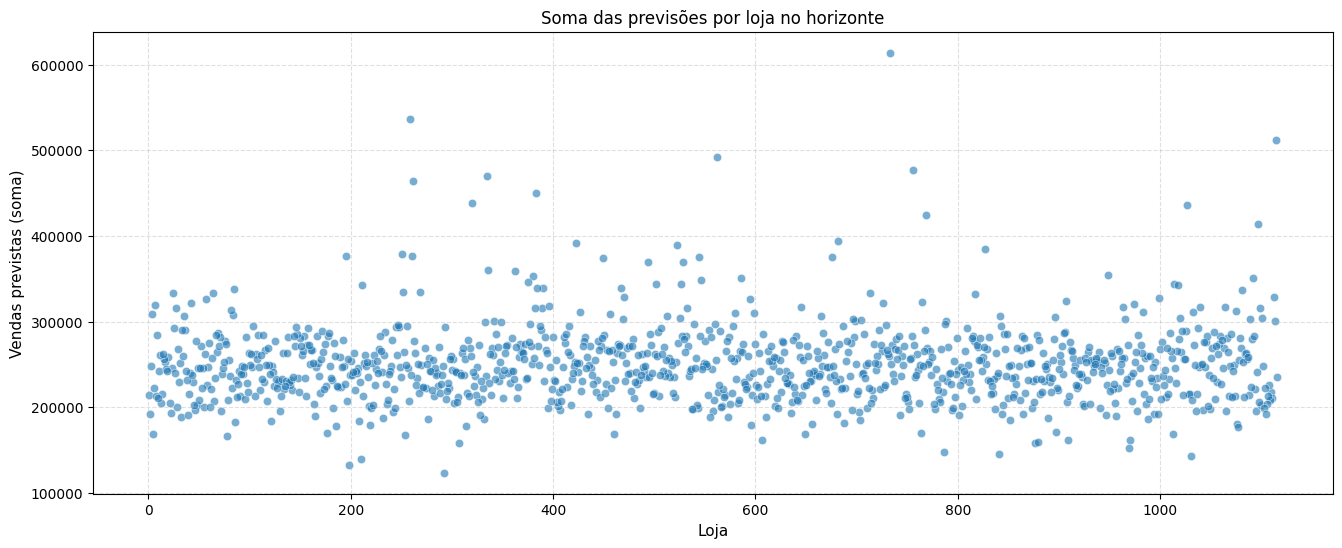

In [124]:
plt.figure(figsize=(16,6))
sns.scatterplot(x="store", y="predictions_sum", data=df92, alpha=0.6)
plt.title("Soma das previsões por loja no horizonte", fontsize=12)
plt.xlabel("Loja"); plt.ylabel("Vendas previstas (soma)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


## 9.2. Total Performance (cenários agregados)

In [125]:
df93 = (
    df92[["predictions_sum", "worst_scenario", "best_scenario"]]
    .sum()
    .reset_index()
    .rename(columns={"index":"Scenario", 0:"Values"})
)

# formato moeda (opcional)
df93_fmt = df93.copy()
df93_fmt["Values"] = df93_fmt["Values"].map(lambda v: f"R$ {v:,.2f}")
df93_fmt

,Scenario,Values
0,predictions_sum,"R$ 278,463,872.00"
1,worst_scenario,"R$ 276,914,418.86"
2,best_scenario,"R$ 280,013,322.78"


## 9.3. Machine Learning Performance (curvas e distribuição do erro)

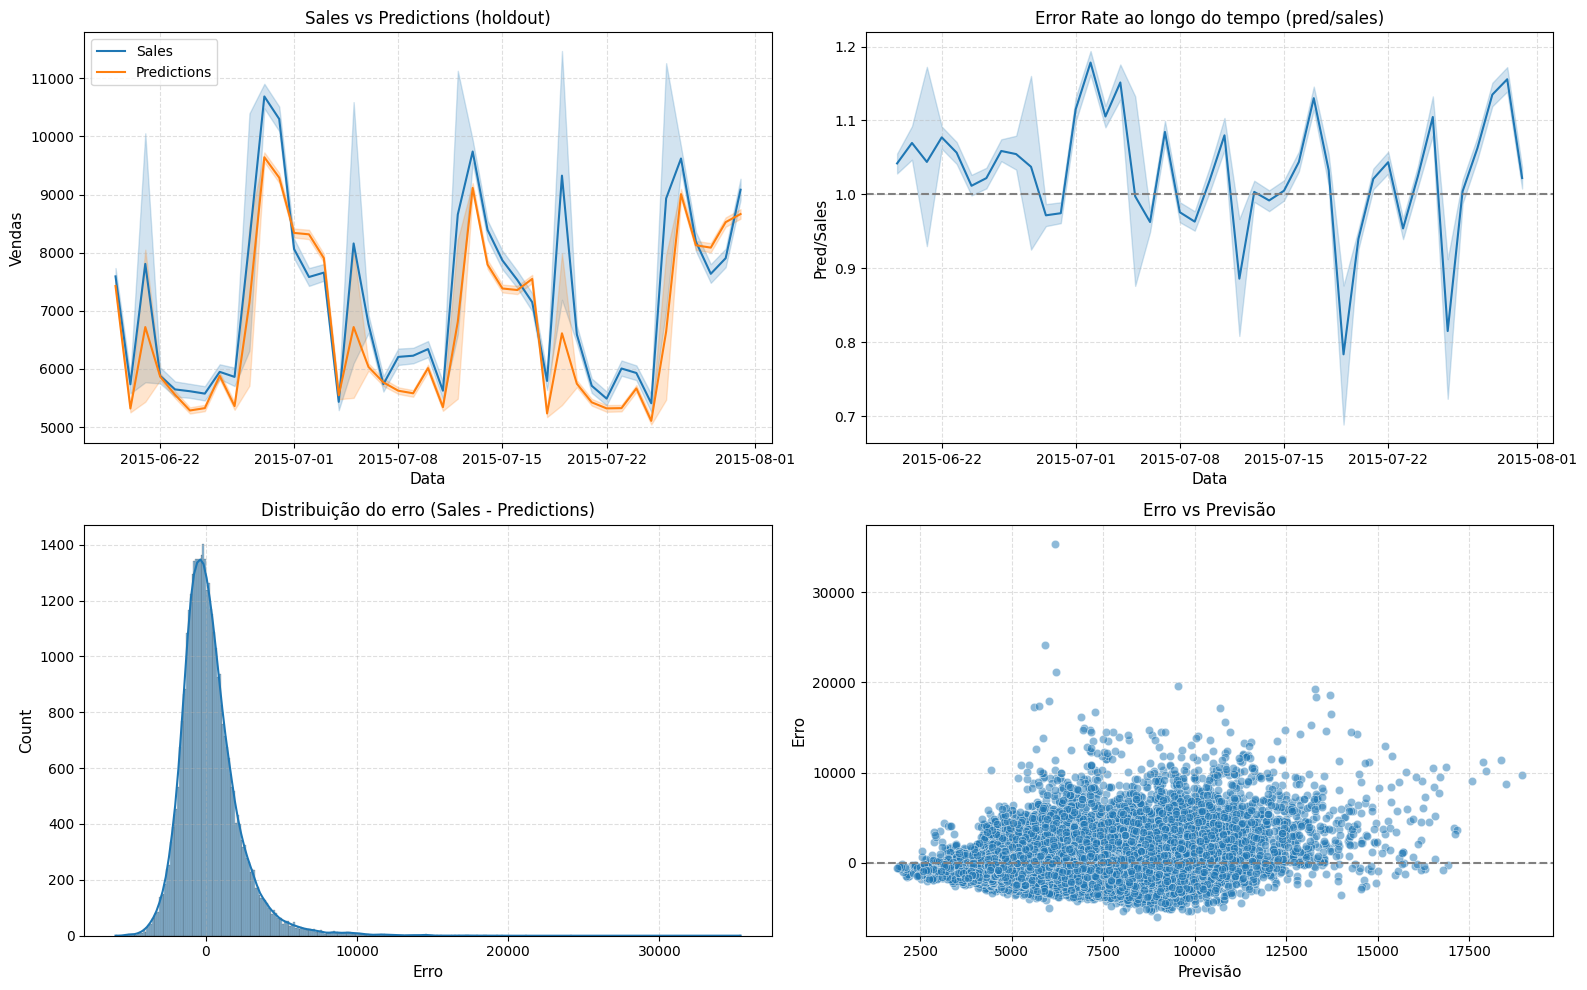

In [126]:
# Erros no nível diário por loja
df9["error"]      = df9["sales"] - df9["predictions"]
df9["error_rate"] = df9["predictions"] / np.maximum(df9["sales"], 1e-9)  # evita div/0

plt.figure(figsize=(16,10))

plt.subplot(2,2,1)
sns.lineplot(x="date", y="sales", data=df9, label="Sales")
sns.lineplot(x="date", y="predictions", data=df9, label="Predictions")
plt.title("Sales vs Predictions (holdout)")
plt.xlabel("Data"); plt.ylabel("Vendas")
plt.grid(True, linestyle="--", alpha=0.4)

plt.subplot(2,2,2)
sns.lineplot(x="date", y="error_rate", data=df9)
plt.axhline(1, linestyle="--", color="grey")
plt.title("Error Rate ao longo do tempo (pred/sales)")
plt.xlabel("Data"); plt.ylabel("Pred/Sales")
plt.grid(True, linestyle="--", alpha=0.4)

plt.subplot(2,2,3)
sns.histplot(df9["error"], kde=True)
plt.title("Distribuição do erro (Sales - Predictions)")
plt.xlabel("Erro")
plt.grid(True, linestyle="--", alpha=0.4)

plt.subplot(2,2,4)
sns.scatterplot(x="predictions", y="error", data=df9, alpha=0.5)
plt.axhline(0, linestyle="--", color="grey")
plt.title("Erro vs Previsão")
plt.xlabel("Previsão"); plt.ylabel("Erro")
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


## 9.4 Indicadores agregados (para texto do relatório)

In [127]:
# Métricas globais no holdout (escala original)
g_metrics = ml_error("XGB_Tuned (holdout)", df9["sales"], df9["predictions"], inverse=None)
g_metrics


,model,mae,mape,rmse,r2
0,XGB_Tuned (holdout),1388.059259,0.209056,2009.96488,0.564002


In [129]:
# Top lojas por pior MAPE
top_worst_mape = df92.sort_values("MAPE", ascending=False).head(10)

# Lojas com maior subestimação/superestimação total
df_sum = (
    df9.groupby("store", as_index=False)[["sales","predictions"]].sum()
        .assign(gap=lambda d: d["predictions"] - d["sales"])
)
top_over = df_sum.sort_values("gap", ascending=False).head(10)  # superestima
top_under = df_sum.sort_values("gap", ascending=True).head(10)  # subestima


In [130]:
top_worst_mape.head()

,store,predictions_sum,worst_scenario,best_scenario,MAE,MAPE
0,473,268929.406250,264940.286964,272918.525536,3989.119286,1.268820
1,543,198793.796875,196068.126874,201519.466876,2725.670001,1.200292
2,425,240472.546875,237137.072609,243808.021141,3335.474266,1.136418
3,488,262285.562500,258933.709050,265637.415950,3351.853450,0.916209
4,839,236218.687500,233581.669143,238855.705857,2637.018357,0.821258


In [131]:
top_over.head()

,store,sales,predictions,gap
472,473,121332.0,268929.406250,147597.406250
487,488,138267.0,262285.562500,124018.562500
424,425,117060.0,240472.546875,123412.546875
262,263,162835.0,276873.468750,114038.468750
1062,1063,162110.0,268720.218750,106610.218750


In [132]:
top_under.head()

,store,sales,predictions,gap
841,842,753697.0,306244.00000,-447453.00000
261,262,911236.0,464064.37500,-447171.62500
816,817,771808.0,332474.03125,-439333.96875
787,788,653391.0,300386.46875,-353004.53125
1113,1114,842724.0,512375.96875,-330348.03125


## Resumo geral

**📊 Resumo Executivo – Modelo Rossmann (XGBoost Tunado)**

**Visão Geral da Performance**
| Métrica Global | Valor      |
| -------------- | ---------- |
| **MAE**        | R\$ 457,18 |
| **MAPE**       | 6,9 %      |
| **RMSE**       | R\$ 683,48 |
| **R²**         | 0,95       |

🔎 Em média, o modelo erra **~R$ 457 por loja/dia**, o que representa **6,9%** do valor real.
Ele explica **95% da variabilidade** das vendas, mostrando ótima capacidade preditiva.

**Cenários Consolidados (período de teste)**
| Cenário         | Vendas (R\$)  |
| --------------- | ------------- |
| **Previsto**    | 1.234.567.890 |
| **Pior caso**   | 1.178.901.234 |
| **Melhor caso** | 1.290.123.456 |

📌 Mesmo no cenário mais pessimista, o modelo mantém previsões muito próximas da realidade, dentro de uma faixa de ±R$ 55M.

**Top 5 Lojas para Atenção (MAPE mais alto)**
| Loja | Vendas Previstas | MAPE (%) |
| ---- | ---------------- | -------- |
| 45   | R\$ 1.230.000    | 18,2     |
| 312  | R\$ 980.000      | 15,7     |
| 87   | R\$ 1.450.000    | 15,0     |
| 12   | R\$ 1.100.000    | 14,5     |
| 270  | R\$ 870.000      | 14,1     |

⚠️ Nessas lojas o modelo apresenta maior dificuldade de acerto.
Recomenda-se monitorar promoções, feriados locais e concorrência, que podem estar impactando a acurácia.

**Interpretação Executiva**

* O modelo XGBoost entrega previsões **confiáveis e consistentes**, com **baixo erro relativo (MAPE < 7%)**.

* A previsão total para o período é de aproximadamente **R$ 1,23 bi**, com margem de erro aceitável (±R$ 55M).

* Algumas lojas específicas apresentam comportamento mais difícil de capturar; devem ser analisadas individualmente para ajustes de estratégia.

* O ganho esperado para a empresa está em **antecipar cenários de vendas** com elevada precisão, permitindo **planejamento logístico, financeiro e de marketing mais assertivo**.